# Data Generation and Analysis Workshop

## Monday October 7, 2024 - Getting Started (2/2) - Data Analysis

Learn how to quickly setup and run an MCMC on this dataset to estimate the source parameters.

In the course of this session we will:

1. Install all necessary packages.
2. Define the basics of Markoc Chain Monte Carlo (MCMC).
3. Apply to simple problems.
4. Use the single MBHB injection from "Getting Started (1/2)" to do noiseless parameter estimation.

*Authors: N. Karnesis, M. Katz, S. Marsat.*

### 0. Requirements
Mount Google Drive to load simulation data

Install and import the required packages

In [ ]:
# requirements for the lisa-data-challenge package
!apt-get install libgsl-dev
!apt-get install libfftw3-dev
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
# installations
!pip install lisa-data-challenge lisabeta chainconsumer eryn latex

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgsl27 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl27 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,351 kB of archives.
After this operation, 10.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl-dev amd64 2.7.1+dfsg-3 [1,257 kB]
Fetched 2,351 kB in 0s (9,629 kB/s)
Selecting previously unselected package libgslcblas0:amd64.
(Reading database ... 123620 files and directories currently installed.)
Preparing to unpack .../lib

In [ ]:
# import system libraries
import logging
import sys, copy
# import scientific libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import h5py
import pandas as pd
# import data analysis libraries
from ldc.waveform.lisabeta import FastBHB
import lisabeta.lisa.lisa as lisa
from lisabeta.lisa.lisa import EvaluateTDIFreqseries
import lisabeta.tools.pyspline as pyspline
import lisabeta.lisa.lisatools as lisatools
import lisabeta.tools.pytools as pytools
from ldc.common import tools
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import lisaconstants
# import sampler libraries
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

# update plot parameters (make it a bit fancier)
rcparams = {}
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'serif'
rcparams['font.size'] = 22
rcparams['legend.fontsize'] = 16
rcparams['text.usetex'] = True
rcparams['mathtext.fontset'] = "stix"
mpl.rcParams.update(rcparams)


In [ ]:
# set logging level to INFO (more verbose and informative)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# A. Basics of [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)

The MCMC algorithms is a class of algorithms based on stochastic search of a given surface. By 'stochastic' we mean that we allow for a degree of stochasticity during this search. The more steps the algorithm takes, the better it converges to the target distribution (theoretiacally at least). An example of this type of algorithm is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). It basically goes as:

1. Start by defining an initial $\vec{\theta}_0$
2. Draw a new point $\vec{\theta}'$ from a proposal distribution $q(\vec{\theta}' | \vec{\theta}_0)$
3. Accept or reject $\vec{\theta}'$ based on a probability. We calculate the accpetance ratio, which is
$\alpha = \mathrm{min} \left\{1,\; \frac{\Lambda(\vec{\theta}') q(\vec{\theta}_0 | \vec{\theta}') }{ \Lambda(\vec{\theta}_0) q(\vec{\theta}' | \vec{\theta}_0)} \right\}$
4. Go to (2) and repeat, until you build an MCMC chain, which in principle after a few iterations should converge to the target distribution.

<img src=http://revolution-computing.typepad.com/.a/6a010534b1db25970b019aff4a7bbc970d-pi width="500">

<sup>By https://blog.revolutionanalytics.com/ </sup>

Go to [this](https://chi-feng.github.io/mcmc-demo/) website to play with different sampler types!

> **More details**: As the name suggests, the idea behind the MCMC method is to mix Monte Carlo methods and Markov Chains. A Markov chain $\left\{ \zeta(t)\right\}$ is a sequence of dependent random variables such that the probability distribution of $\zeta(t)$ given the past variables depends only on $\zeta(t-1)$. This conditional probability distribution is called a _transition kernel_ or a _Markov kernel_ $K$. Eventually, the aim is to construct Markov chains that follow the desired _target, stationary_ distribution. The existence of a stationary distribution requires  that the kernel $K$  allows for free moves in over all the parameter space (or in other words, there is always a positive probability of reaching any point in the parameter space). The kernel and stationary distribution $f$, must satisfy $\int_\mathcal{Z} K(x,y)f(x){\mathrm d} x = f(y)$. Another prerequisite is the so-called _ergodicity_ of the chains. This means that a kernel $K$ that produces ergodic Markov chains with a stationary distribution $f$, will generate simulations from $f$. Then, if all requirements are met, any average of $g$ can be approximated with the _Ergodic Theorem_
>
> $\frac{1}{T} \sum^T_{t=1} g(\zeta(t)) \rightarrow \left< g(\zeta) \right>$ (§).
>
> Yet, the working principe of a MCMC is to construct a target density $f$, together with a Markov kernel $K$ with $f$ being its stationary distribution, to generate Markov chains, and finally to evaluate the integral using eq.~(§). While there could be frustration in the choice of a suitable Markov kernel, the solution is to choose one that can be arbitrary up to a certain level, like the _MH_ algorithm, to be later generalised by W. K. Hastings. The trick is to link the target distribution $f$ to an arbitrary conditional density $q$ that is easy to simulate in practice.

Samplers out there:

**MCMC samplers**:
1. emcee
2. PyMC3
3. TensorFlow Probability
4. Zeus
5. PyStan
6. PyJAGS
7. [Eryn!](https://github.com/mikekatz04/Eryn)

**Nested samplers**:
1. Nestle
2. CPNest
3. dynesty
4. UltraNest
5. PyMultiNest
6. DNest4
7. PyPolyChord

* _Can we build a basic MCMC setup?_


In [ ]:
def log_like_gauss(x):
    return -0.5 * x ** 2 - 1/2 * np.log(2 * np.pi * 1.0) # 1.0 is sigma

Text(0.5, 0, '$x$')

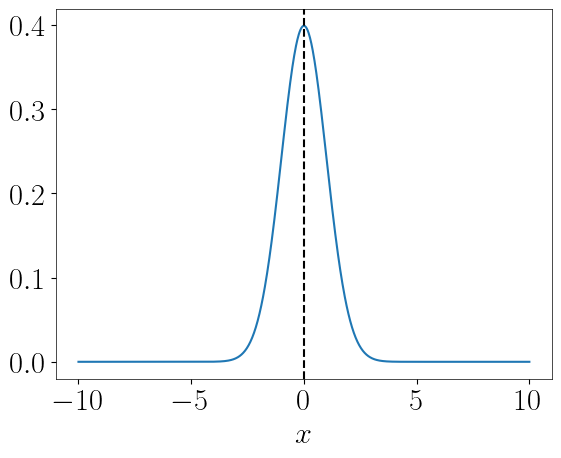

In [ ]:
x_vals = np.linspace(-10.0, 10.0, 1000)

# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.axvline(0.0, linestyle='--', color='k')
plt.xlabel("$x$")

In this notebook, we will be using the Eryn software. It's basically a Bayesian sampler on steroids, because it is capable of reversible jump sampling, with parallel tempering methods on top! Check the [documentation](https://mikekatz04.github.io/Eryn/html/index.html) and [examples](https://mikekatz04.github.io/Eryn/html/tutorial/more_tutorials.html) for more details. There is also a paper which can be found [here](https://arxiv.org/abs/2303.02164).

Any other sampler would work fine for this particular notebook.

First we define the prior limits:

In [ ]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})

Then we setup the sampler by choosing the number of _walkers_. Here we do not use the parallel tempering yet.

In [ ]:
nwalkers = 20
ndim = 1
sampler = EnsembleSampler(nwalkers, 1, log_like_gauss, prior)

We need to define the starting points on the parameter space, or the initial _state_. We use the `prior.rvs` functionb to draw initial points for each walker. In principle, and function could be used here.

In [ ]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

Start the MCMC:

In [ ]:
end_point = sampler.run_mcmc(start_state, 10000, progress=True)

100%|██████████| 10000/10000 [00:47<00:00, 209.63it/s]


Plot the chains here:

Text(0.5, 0, 'Samples')

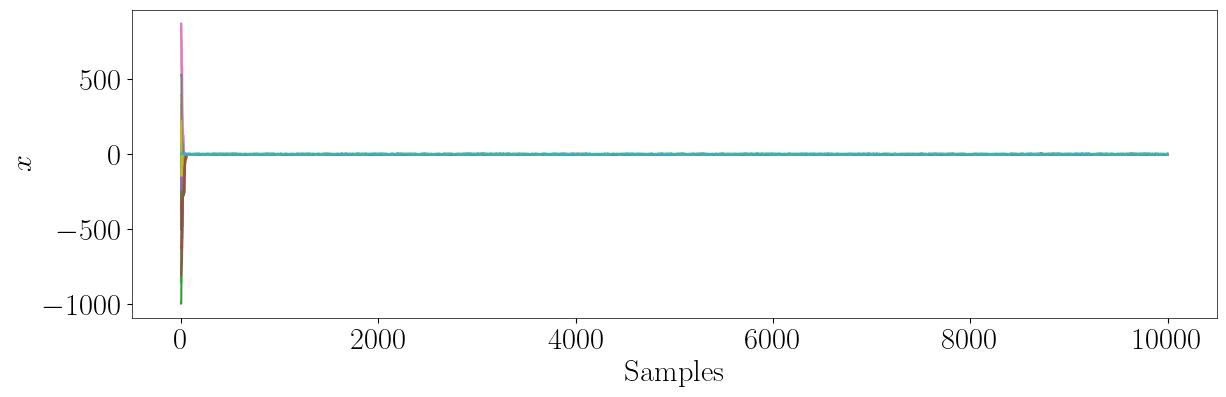

In [ ]:
samples = sampler.get_chain()["model_0"]

plt.figure(figsize=(14,4))
for w in range(nwalkers):
    plt.plot(samples[:, 0, w, 0])

plt.ylabel("$x$")
plt.xlabel("Samples")

We now plot the result against the theoretical model:

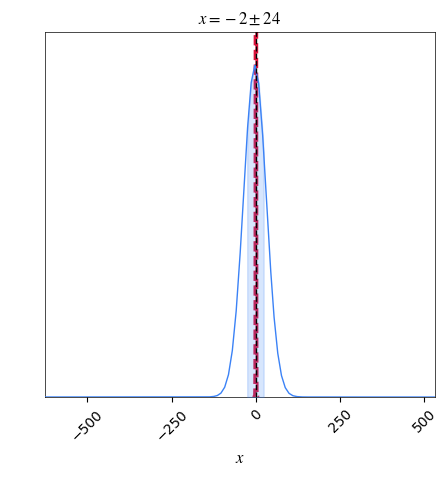

In [ ]:
sdf = pd.DataFrame(samples.flatten(), columns=["$x$"])

c = ChainConsumer()
c.add_chain(Chain(samples=sdf, name="A first PE example"))
c.add_truth(Truth(location={"$x$": 0}))

fig = c.plotter.plot()

# Plot the "true" likelihood we have defined
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)), linestyle='--', color='crimson', lw=2)

mpl.rcParams.update(rcparams) # We do this each time because chainconsumer
                              # changes our mpl settings.

We need to discard the first points and keep those that are sampling a stationary distribution (have converged). There are  ways to compute the number of samples to discard, but usually it's done empirically.

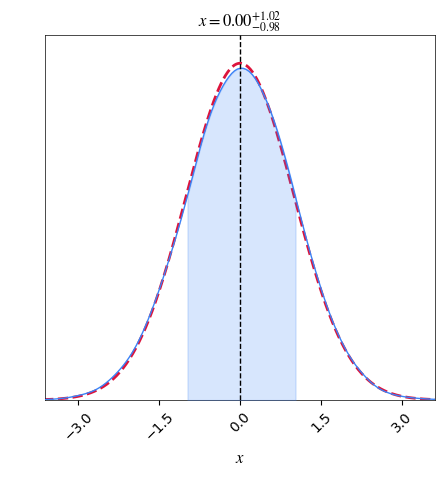

In [ ]:
burn = 1000 # BURN!

sdf = pd.DataFrame(samples[burn:].flatten(), columns=["$x$"])

c = ChainConsumer()
c.add_chain(Chain(samples=sdf, name="A first PE example"))
c.add_truth(Truth(location={"$x$": 0}))

fig = c.plotter.plot()

# Plot the "true" likelihood we have defined
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)), linestyle='--', color='crimson', lw=2)

mpl.rcParams.update(rcparams) # We do this each time because chainconsumer
                              # changes our mpl settings.

## Let us begin with a simple toy model

We begin with the assumption of a measurement; a vector of data samples, $\mathbf{d}$, that will consist of the model defined at a set of $M$ values, $\mathbf{x}$, with additive Gaussian noise of known standard deviation, i.e., data point $i$ will be defined by

$$
d_i = y(x_i;m,c) + n_i,
$$

with

$$
n_i \sim N(0, \sigma_i),
$$

which means the noise is drawn from a [Gaussian (or Normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution) of zero mean and standard deviation of $\sigma_i$.

> **Note**: I'll generally use the term [Gaussian distribution](https://en.wikipedia.org/wiki/Normal%5fdistribution)
> rather than "Normal" distribution, as this it what I first heard it called. But, in many packages discussed below
> "Normal" is the more common word for the distribution

In principle, we may use whatever underlying physical model we'd like, but let us begin with the ol' reliable and simple linear model. This model has two parameters, $\vec{\theta} = \{m, \,c\}$, and is written as:

$$
y(\mathbf{x};\vec{\theta} = \{m, \,c\}) = m\mathbf{x} + c,
$$

where $\mathbf{x}$ is a vector of values of $x$. This is basically fitting the gradient and $y$-intercept of a straight line, which should be fairly familiar as [linear regression](https://en.wikipedia.org/wiki/Linear_regression), and is obviously a solved problem (*assuming uniform priors!*) using, e.g., [least squares fitting](https://en.wikipedia.org/wiki/Linear_least_squares_%29mathematics%29). This  simple example will be extended to more realistics scenarios.

### Creating the data

So, let's get started creating our data. I'll (arbitrarily) use:

 * $m = 3.5$,
 * $c = 1.2$,

for the model and

 * $\mathbf{x} \in [0, 10)$ in $M=50$ uniform steps ($[a,b)$ means [inclusive of $a$, but exclusive of $b$](https://en.wikipedia.org/wiki/Bracket_%28mathematics%29#Intervals)),
 * $\sigma_i = \sigma = 2$ (i.e., each noise point is independent, but has the same standard deviation),

for the data.

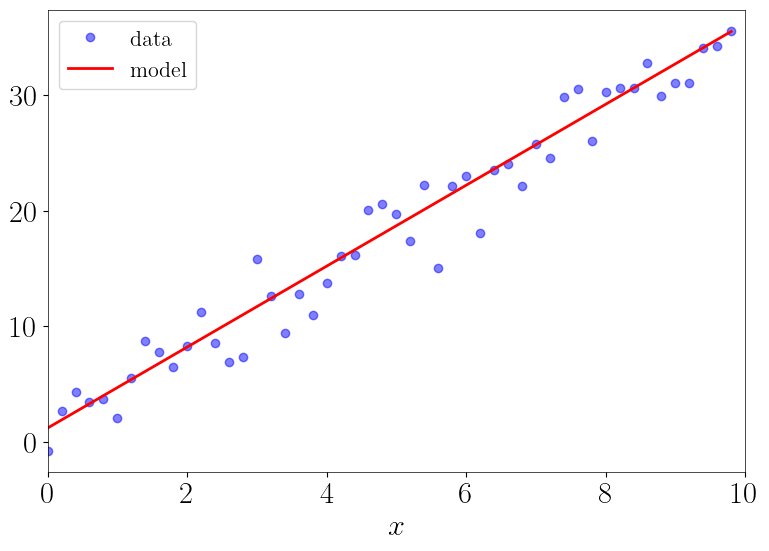

In [ ]:
# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M    = 50
xmin = 0.
xmax = 10.
stepsize = (xmax - xmin) / M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c

    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    return m * x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 2.0  # standard deviation of the noise
data = straight_line(x, m, c) + np.random.normal(scale=sigma, size=M)

# plot the data
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

### Doing things the old fashioned way

We will now solve this problem by using the method of ordinary least squares.

In order to obtain the parameters for the linear regression line for a set of multiple points, we can re-write the problem as matrix equation $\pmb X \; \pmb a = \pmb y$:

$\Bigg[ \begin{array}{cc}
x_1 & 1  \\
... & 1 \\
x_n & 1  \end{array} \Bigg] \bigg[ \begin{array}{c}
m  \\
c \end{array} \bigg] =\Bigg[ \begin{array}{c}
y_1   \\
...  \\
y_n  \end{array} \Bigg]$

where $\pmb a = [m\;c]^T$, and $\pmb a = (\pmb X^T \; \pmb X)^{-1} \pmb X^T \; \pmb y$ (see for example [here](https://towardsdatascience.com/analytical-solution-of-linear-regression-a0e870b038d5) or [here](https://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/readings/notes_on_linear_regression.pdf) for details)

The more classic approach to obtain the slope parameter  a  and y-axis intercept  b  would be:

$m = \frac{S_{x,y}}{\sigma_{x}^{2}}\quad$  (slope)

$c = \bar{y} - m\bar{x}\quad$  (y-axis intercept)

where

$S_{x,y}=\sum^n_{i=1}(x_i−\bar{x})(y_i−\bar{y})$  (covariance)

$\sigma{_x}^{2} = \sum_{i=1}^{n} (x_i - \bar{x})^2\quad$  (variance)

<img src=https://i.imgur.com/EoWWdBj.png width="500">

<sup>By https://blog.stata.com/ </sup>



In [ ]:
def leastsquares(x, y):
    """ Computes the least-squares solution to a linear matrix equation. """
    X = np.vstack([x, np.ones(len(x))]).T
    return (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)



 * I have found: m = 3.4656089027306196 (true=3.5), c = 0.9815416097077443 (true=1.2)




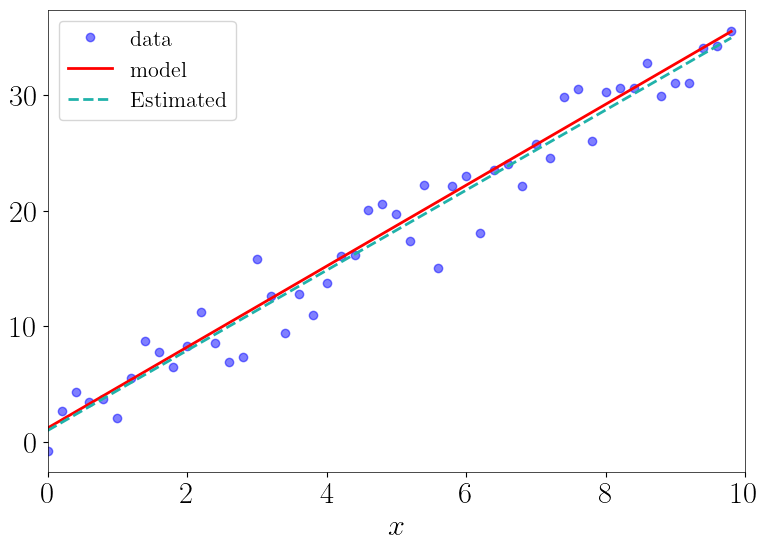

In [ ]:
result = leastsquares(x, data)

# Print coefficients
print('\n\n * I have found: m = {} (true={}), c = {} (true={})\n\n'.format(result[0], m, result[1], c))

# plot the results
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.plot(x, straight_line(x, result[0], result[1]), lw=2, label='Estimated', linestyle='--', color='lightseagreen')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

### Basics on Bayesian statistics

In the framework of Bayesian statistics, we aproach the problem from a different angle. Now, we do not talk about "trials" (i.e. coin flips), but we assume the parameters of interest are themselves random variables. At the same time we are able to use our prior beliefs to the problem. A prior encapsulates basically any information that is available before inference.

In the context of Bayesian parameter estimation, e.g., we have a model, $y$, defined by a set of parameters, ${\vec{\theta}}$, with certain prior probability distributions $p(\vec{\theta}|I)$, and we want to efficiently sample from the marginalised posterior probability distributions on those parameters given some data, $\mathbf{d}$, and a particular [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function), $p(\mathbf{d}|\vec{\theta},I)$, ($I$ is just a substitute for all the implicit assumptions that have gone into defining our model). From Bayes theorem we have the joint posterior on the whole set of parameters,

$$
p(\vec{\theta}|\mathbf{d},I) = \frac{p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I)}{p(\mathbf{d}|I)},
$$

The $p(\mathbf{d}|I)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood), or *evidence*, for the data given the particular model used, and is given by

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

which is a normalising constant for the posterior.

> **Note:** This normalization constant might not be relevant for PE, but it's crucial for Bayesian model selection.

Our aim is to describe the posterior probability of the given system. One way to do this is to produce samples drawn from the $p(m, c|\mathbf{d},I)$, which can be used (by, e.g., histogramming the sample values) to approximate the marginal posteriors $p(m|\mathbf{d},I)$ and $p(c|\mathbf{d},I)$.


### Getting started: Setting the likelihood

A sensible and fairly standard likelihood function (due to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) and [maximum entropy arguments](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution#Specified_variance:_the_normal_distribution)) for a single data point given values of $m$ and $c$ and a known noise standard deviation, will be given by a Gaussian distribution of the form

$$
p(n_i|m,c,I) = \left(2\pi\sigma_i^2\right)^{-1/2} \exp{\left(-\frac{\left[n_i\right]^2}{2\sigma_i^2} \right)},
$$

$$
p(d_i|m,c,I) = \left(2\pi\sigma_i^2\right)^{-1/2} \exp{\left(-\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)},
$$

and the joint likelihood for the whole dataset of $n$ points (assuming independent noise \[!\] ) will be the product of the individual likelihoods

$$
p(\mathbf{d}|m,c,I) = \prod_{i=1}^n p(d_i|m,c,I) = \left(2\pi\right)^{-n/2}\left(\prod_{i=1}^n \sigma_i^{-1} \right) \exp{\left(-\sum_{i=1}^n\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)}.
$$

When computing likelihoods, numerical considerations mean that one almost always works with the natural logarithm of the likelihood, so we have

$$
\ln{p(\mathbf{d}|m,c,I)} \equiv \log{L} = -\frac{n}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^n \sigma_i\right) - \sum_{i=1}^n\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}.
$$

For many cases we can ignore the terms that do not include our required parameters when sampling from their marginalised likelihoods (as they will just be constants), so often the log-likelihood can be set to be

$$
\log{L} = - \sum_{i=1}^n\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}.
$$

> **Note**: If wanting to evaluate the marginal likelihood for the data (e.g., using nested sampling)
> to use it for [model comparison](https://en.wikipedia.org/wiki/Bayes%5ffactor), the constants
> may be required.

In [ ]:
def loglikelihood(theta):
    """
    The natural logarithm of the joint Gaussian likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined

    Note:
        We do not include the normalisation constants (as discussed above).
    """

    # unpack the model parameters from the tuple
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data) / sigma)**2)

### Setting the prior

In addition to the likelihood, we need to define [prior](https://en.wikipedia.org/wiki/Prior_probability) distributions on the parameters. We will use a uniform probability distribution for both parameters, for example:

$$
p(c|c_{\rm min}, c_{\rm max}) = \Bigg\{\begin{array}{cl}
\frac{1}{c_{\rm max}-c_{\rm min}} & \text{if}~c_{\rm min} < c < c_{\rm max}, \\
0 & \text{otherwise}.
\end{array}
$$

In our example we can set:

 * $\mu_{\rm min} = -20$ and $\mu_{\rm max} = 20$,
 * $c_{\rm min} = -10$ and $c_{\rm max} = 10$.


If we use the Eryn infrastructure, then we need to use the `ProbDistContainer`. For more details see [here](https://mikekatz04.github.io/Eryn/html/user/prior.html).

In [ ]:
prior = ProbDistContainer({
    0: uniform_dist(-20.0, 20.0),
    1: uniform_dist(-10.0, 10.0)
})

As already mentioned, one can use other tools as well. For example, to make it work with `emcee`, we would need to define prior and posterior functions as well, like below:
```
def logprior(theta):
    """
    The natural logarithm of the prior probability.
    """
    lp = 0.
    # uniform prior on theta
    cmin, cmax = -10., 10 # Range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    # (we don't care about it being properly normalised, but you can if you want)
    lp = 0. if cmin < theta < cmax else -np.inf
    return lp
```
And for the pooterior:
```
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.
    """
    lp = logprior(theta) # get the prior
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, data, sigma, x)
```
Then we can run the `emcee` as
```
argslist = (data, sigma, x)
sampler = emcee.EnsembleSampler(Nwalkers, ndims, logposterior, args=argslist)
sampler.run_mcmc(x0, Nsamples);
```


Let us continue with `Eryn`, which is essentially a version of `emcee` with extra features:

In [ ]:
# set up the sampler
sampler_line = EnsembleSampler(nwalkers, 2, loglikelihood, prior, )

In [ ]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

In [ ]:
end_point = sampler_line.run_mcmc(start_state, 10000, progress=True)

100%|██████████| 10000/10000 [00:29<00:00, 333.44it/s]


In [ ]:
samples = sampler_line.get_chain()["model_0"][:, 0].reshape(-1, 2)

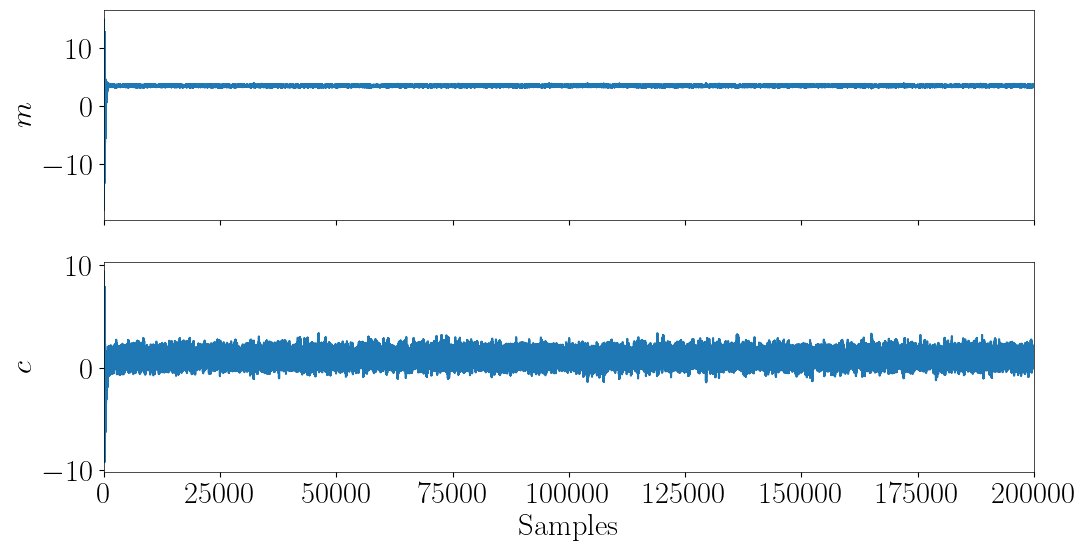

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True)
axs[0].plot(samples[:,0], )
axs[0].set_ylabel('$m$')

axs[1].plot(samples[:,1], )
axs[1].set_ylabel('$c$')
axs[1].set_xlabel('Samples')
axs[1].set_xlim(0, samples.shape[0])

plt.show()

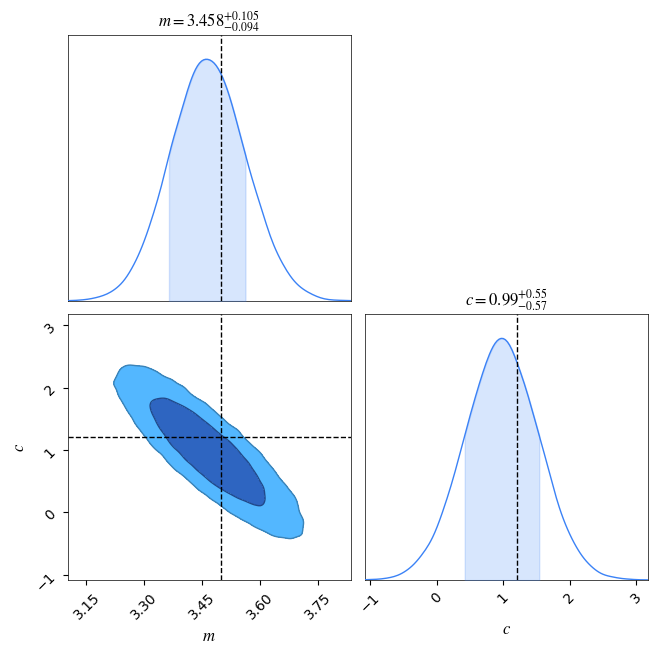

In [ ]:
burn = 10000

sdf = pd.DataFrame(samples[burn:,:], columns=["$m$", "$c$"])

ch = ChainConsumer()
ch.add_chain(Chain(samples=sdf, name="A second PE example"))
ch.add_truth(Truth(location={"$m$": m, "$c$": c}))
fig = ch.plotter.plot()

mpl.rcParams.update(rcparams)

# B. MCMC & Gravitational Waves from MBHBs

In this section we will apply MCMC algorithms on the case of MBHB signals as measured by LISA. We will use the same binary as in the previous section, but we will focus on a noiseless analysis.

We will be using the `lisabeta` software developed by S. Marsat _et al_ ([2003.00357](https://arxiv.org/abs/2003.00357)), which is available with the `ldc` software. Besides `lisabeta` we could also use [`BBHx`](https://github.com/mikekatz04/BBHx) developed by M. Katz, or any other suitable package.

The parameters of the binary are given below:

In [ ]:
pMBHB_ldc = {
            'EclipticLatitude': -0.30300442294174235,
            'EclipticLongitude': 1.2925183861048521,
            'PolarAngleOfSpin1': 1.2031361791056812,
            'PolarAngleOfSpin2': 2.097303543065685,
            'Spin1': 0.747377,
            'Spin2': 0.8388,
            'Mass1': 1323277.47932,
            'Mass2': 612485.5060299999,
            'CoalescenceTime': 11526944.921879262,
            'PhaseAtCoalescence': 1.2201968860015653,
            'InitialPolarAngleL': 2.6919824500032945,
            'InitialAzimuthalAngleL': 1.808398497592109,
            'Redshift': 1.73941,
            'Distance': 13449.011,
            'ObservationDuration': 31558149.763545603,
            'Cadence': 3.0}

## B.1 Signal generation

Lets assume a time step and a total observation time for our simulated signal.

In [ ]:
dt = 5
tmax = 3.155815e+05 # in [sec]

We need to instantiate the class given the above settings. `lisabeta` requires a specific parametrisation (and parameter names), which is slightly different to the standard `ldc` naming conventions. We can do the transformation with the `rename_as_lisabeta` function.

In [ ]:
FBH = FastBHB("MBHB", T=tmax, delta_t=dt, approx="IMRPhenomD")

pMBHB = FBH.rename_as_lisabeta(pMBHB_ldc)

print(pMBHB.keys())

dict_keys(['beta', 'lambda', 'chi1', 'chi2', 'm1', 'm2', 'Deltat', 'phi', 'dist', 'psi', 'inc'])


Next, we need to define some extra settings for hte waveform. The most important for now, are the `TDI`, `t0`, `modes`, `timetomerger_max`, and the `approximant`. Sylvain can offer more details about the different software settings.

The waveform is decomposed in several parts:
$$ TDI_A(f) = T_A(t,f) A(f) e^{i\Psi(f)} $$
    
   * Response:  $T_A(t,f)$ is a complax function
   * Phase in frequency domain $\Psi(f)$
    
Both are slow varying functions. The overall amplitude is $A = T_A(t,f) A(f)$

In [ ]:
waveform_params_smbh = {
    "minf": 1e-5,
    "maxf": 1,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "tmax": 1.0,
    "TDI": "TDI2AET",
    "approximant": "IMRPhenomD",
    "TDIrescaled": False,
}

Compute the waveform given the injection parameters:

In [ ]:
tdisignal = lisa.GenerateLISATDISignal_SMBH(pMBHB, **waveform_params_smbh)

Investigate the output. It's the TDI of the noiseless waveform (three channels), and some other basic information.

In [ ]:
print(tdisignal.keys())

dict_keys(['SNR', 'SNR2modematrix', 'wftdi', 'tdi', 'weightedtdi'])


In [ ]:
tdi = tdisignal['tdi']

print('content', tdi.keys())
print(tdi[(2,2)].keys())

content dict_keys(['modes', (2, 2)])
dict_keys(['freq', 'phase', 'amp_real_chan1', 'amp_imag_chan1', 'amp_real_chan2', 'amp_imag_chan2', 'amp_real_chan3', 'amp_imag_chan3'])


In [ ]:
print ('Using ', len(tdi[(2,2)]['freq']), 'frequencies' )
print ('total SNR of the source:', tdisignal['SNR'])

Using  265 frequencies
total SNR of the source: 2234.6295039215306


In [ ]:
mbh_lb = tdi[(2,2)] # get components of the waveform out

Plot the phase, and real and imaginary parts of the waveform.

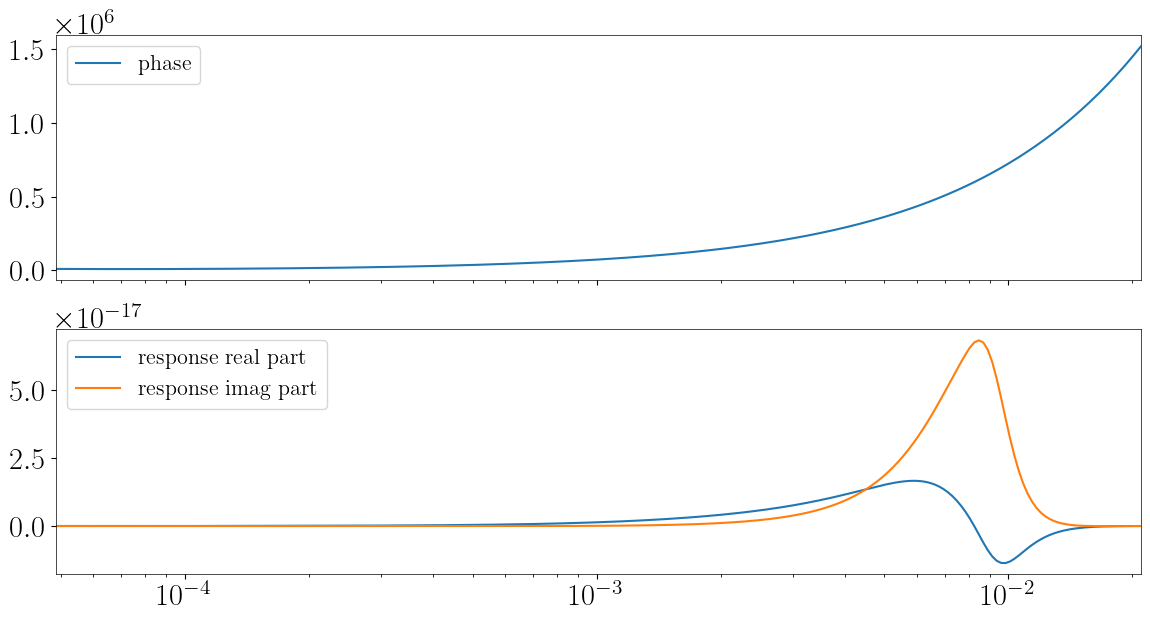

In [ ]:
fig, ax = plt.subplots(figsize=(14,7), nrows=2, ncols=1, sharex=True)
ax[0].semilogx(mbh_lb['freq'], mbh_lb['phase'], label="phase")
ax[0].legend(loc = 'upper left')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_real_chan1'], label='response real part')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_imag_chan1'], label='response imag part')
ax[1].legend(loc = 'upper left')
plt.axis([mbh_lb['freq'][0], mbh_lb['freq'][-1], None, None])
plt.show()

Plot the PSD of the signal now. First we will need to compute the full frequency array for the assumed measurement.

In [ ]:
 # frequency band of the signal
fmin = mbh_lb['freq'][0]
fmax = mbh_lb['freq'][-1]
ndata = int(tmax/dt)
df = 1/tmax

# Get the full frequencies
if (ndata % 2)==0:              # Get the number of requencies
    nfft = int((ndata/2)+1)
else:
    nfft = int((ndata+1)/2)

F = df*nfft                 # make the positive frequency vector
fvec = np.arange(0, F, df)

# Get the frequencies of interest
f_inds = np.where(np.logical_and(fvec >= fmin, fvec < fmax))
fvec = fvec[f_inds]

Now, we need to spline the parts of the signal and construct the signal at each Fourier frequency. We will first do that for a single channel:

In [ ]:
# constructing spline
splPh = spline(mbh_lb['freq'], mbh_lb['phase'], ext='raise') # Note the raise!
splAr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan1'])
splAi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan1'])

# constructing signal at each Fouriner freq.
Afull = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*splPh(fvec)))

A simpler way to do this, is to use the internal functions of `lisabeta`. We use the `EvaluateTDIFreqseries` as:

In [ ]:
Afull_another_way = np.conj(EvaluateTDIFreqseries(tdisignal['tdi'], fvec)[(2, 2)]['chan1'])

Now we can plot them together, and they should return the same result.

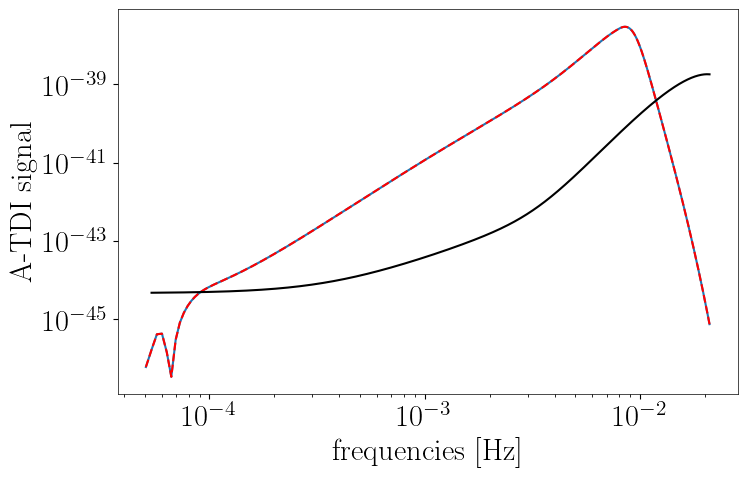

In [ ]:
# adding the noise
Nmodel = AnalyticNoise(fvec[1:], model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

plt.figure(figsize=(8,5))

plt.loglog(fvec, 2*df*np.abs(Afull)**2)
plt.loglog(fvec, 2*df*np.abs(Afull_another_way)**2, 'r--')

plt.loglog(fvec[1:], Npsd, 'k')

plt.ylabel("A-TDI signal")
plt.xlabel("frequencies [Hz]")
plt.show()

Lets do the same for the rest of the channels and plot them together:

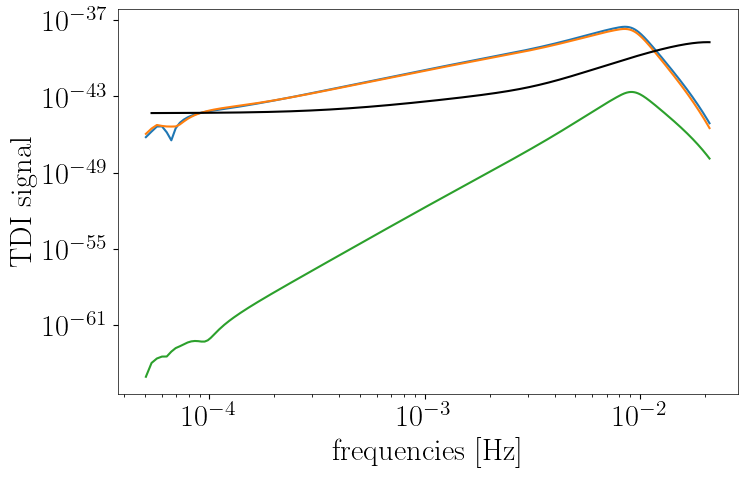

In [ ]:
# constructing spline of E
splEr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan2'])
splEi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan2'])

# constructing signal at each Fouriner freq. for E channel
Efull = np.conjugate((splEr(fvec) + 1.j*splEi(fvec))*np.exp(1j*splPh(fvec)))

# constructing spline of E
splTr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan3'])
splTi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan3'])

# constructing signal at each Fouriner freq. for E channel
Tfull = np.conjugate((splTr(fvec) + 1.j*splTi(fvec))*np.exp(1j*splPh(fvec)))

plt.figure(figsize=(8,5))
plt.loglog(fvec, 2*df*np.abs(Afull)**2, label='A')
plt.loglog(fvec, 2*df*np.abs(Efull)**2, label='E')
plt.loglog(fvec, 2*df*np.abs(Tfull)**2, label='T')

plt.loglog(fvec[1:], Npsd, 'k')

plt.ylabel("TDI signal")
plt.xlabel("frequencies [Hz]")
plt.show()

To compute likelihood/SNR we need to define the inner product for real time series $a$ and $b$:
$$ (a | b) = 4 \Re \int_{f>0} \frac{\tilde{a}(f) \tilde{b}^*(f)}{S_n(f)}\, df$$

which is approximated as a sum:
$$
4 \Re \sum_i \frac{\tilde{a}(f_i) \tilde{b}^*(f_i)}{S_n(f_i)} \Delta f
$$
where $(\tilde{\,\,})$ denotes the Fourier transform.

For a signal $s$ (in our case, $s$ is a TDI channel) the optimal SNR is:
$$
\mathrm{SNR}^2 = (s|s)
$$

For Gaussian, stationary noise, the log-likelihood for a a single GW source is simply:
$$
\Lambda (d|\theta) = -\frac{1}{2} (s(\theta) - d|s(\theta) - d)
$$
Here $d = s(\theta_0) + n$ is the detector data, with $n$ the detector noise realization and $s(\theta_0)$ is the true signal.

The TDI channels A,E,T, linear combinations of X,Y,Z are (approximately) independent, and T is a null channel except at high frequencies. This allows to write the likelihood simply as a sum over A,E channels:

$$
\Lambda = -\frac{1}{2} (s_A - d_A|s_A - d_A) -\frac{1}{2} (s_E - d_E|s_E - d_E)
$$

Or, we write for each $i$ channel:

$$ -\frac1{2} (d - s_i | d - s_i) = -\frac1{2} (d|d) + (d|s_i) - \frac1{2} (s_i|s_i) \to (d|s_i(\theta)) - \frac1{2} (s_i|s_i)(\theta)$$


In order to save some computational time, we can proceed with **analysing a single TDI channel**. Thus, we will write the likelihood for the equation above:

In [ ]:
def compute_likelihood(D, h, Sn, df):
    SN_m = 4.0*df* np.sum( np.real(D*np.conjugate(h))/Sn )
    XX = 4.0*df*np.sum( np.abs(h)**2/Sn )
    loglik = SN_m - 0.5*XX
    return (SN_m, XX, loglik)

Define the theoretical noise curve using the `AnalyticNoise` class. Then we can get the PSD for a given channel by running its `psd` function as

``
Npsd = analytic_noise_class.psd(option='a_given_channel_here', tdi2=True)
``

In [ ]:
Nmodel = AnalyticNoise(fvec, model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

Let us now compute the SNR and likelihood:

In [ ]:
SN2, XX, loglik =  compute_likelihood(Afull, Afull, Npsd, df)
print (f'for A-TDI: the optimal SNR  {np.sqrt(XX)} and likelihood is {loglik}')

for A-TDI: the optimal SNR  1885.7478996549507 and likelihood is 1778022.570526529


## B.2 Sampling with MCMC

Now that we know how to generate signals in frequency domain, we can proceed with the setup of the sampling scheme. First we choose to sample a different parametrization. At the same time, we will be sampling only a small fraction of the parameters of the waveform. Otherwise our simple MCMC setup would require way too much computational time to converge. Acceleration techniques have been implemented for LISA (see below this section for a list of methods and software).

We sue the mass ratio and the chirp mass, defined as:

$$ q = \frac{m_1}{m_2}$$

$$ M_\mathrm{chirp} = (m_1 + m_2)\left(\frac{q}{(q+1)^2}\right)^{3/5}$$

In [ ]:
m1 = pMBHB['m1']
m2 = pMBHB['m2']

q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

pMBHB["Mchirp"] = Mc
pMBHB["q"] = q

pMBHB_fit = copy.deepcopy(pMBHB)

# Remove those keys, otherwise the code will
# fit for m1 and m2 instead of Mchirp and q.
del pMBHB_fit["m1"]
del pMBHB_fit["m2"]

In [ ]:
pMBHB_fit

{'beta': -0.30300442294174235,
 'lambda': 1.2925183861048521,
 'chi1': 0.26863190922667673,
 'chi2': -0.4215109787709388,
 'Deltat': 11526944.921879262,
 'phi': 1.2201968860015653,
 'dist': 13449.011,
 'psi': -1.8503700516659007,
 'inc': 2.2517895222056112,
 'Mchirp': 772462.8571528315,
 'q': 2.160504152820206}

In [ ]:
# Define which data-set to fit for
D = Afull.copy()

def likelihood(pvector):

    Mc, q, dist = pvector[:]
    pMBHB_fit["Mchirp"] = Mc
    pMBHB_fit["q"] = q
    pMBHB_fit["dist"] = dist

    h_tdi = lisa.GenerateLISATDISignal_SMBH(pMBHB_fit, **waveform_params_smbh)['tdi'][(2,2)]

    splPh = spline(h_tdi['freq'], h_tdi['phase'])
    splAr = spline(h_tdi['freq'], h_tdi['amp_real_chan1'])
    splAi = spline(h_tdi['freq'], h_tdi['amp_imag_chan1'])

    h = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*splPh(fvec)))

    SN_m = 4.0*df* np.sum( np.real(D*np.conjugate(h))/Npsd )
    XX = 4.0*df* np.sum( np.abs(h)**2/Npsd )
    loglik = SN_m - 0.5*XX

    return loglik

In [ ]:
loglik =  likelihood([pMBHB["Mchirp"], pMBHB["q"], pMBHB["dist"]])
print (f'for A-TDI likelihood is {loglik}')

for A-TDI likelihood is 1778022.57052653


In [ ]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 1e7),
    1: uniform_dist(1, 10),
    2: uniform_dist(500.0, 1000000.0),
})}

In [ ]:
ntemps = 5
nwalkers = 20
nsamples = 2000
ndims = {"mbh": 3}

sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)


In [ ]:

injection_params_sub = np.array([pMBHB["Mchirp"], pMBHB["q"], pMBHB["dist"]])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

start_state = State({"mbh": start_params})

sampler.compute_log_prior(start_state.branches_coords);


In [ ]:
sampler.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 2000/2000 [16:06<00:00,  2.07it/s]


Plot the chains again!

Text(0.5, 0, 'Samples')

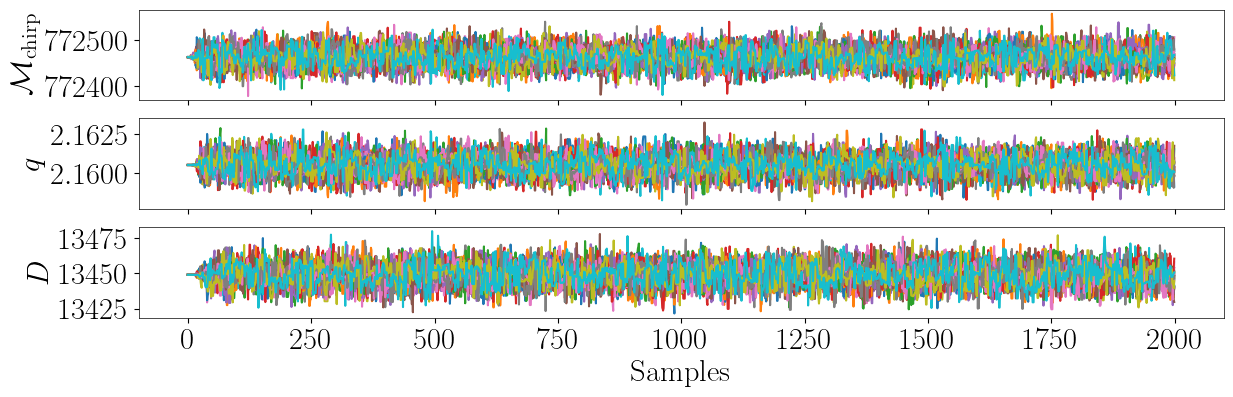

In [ ]:
samples = sampler.get_chain()["mbh"]

pnames = [r"$\mathcal{M}_\mathrm{chirp}$", "$q$", "$D$"]

fig, axs = plt.subplots(nrows=len(pnames), ncols=1, figsize=(14,4), sharex=True)

for i in range(len(pnames)):
  for w in range(nwalkers):
      axs[i].plot(samples[:, 0, w, 0, i])
  axs[i].set_ylabel(pnames[i])

axs[-1].set_xlabel("Samples")

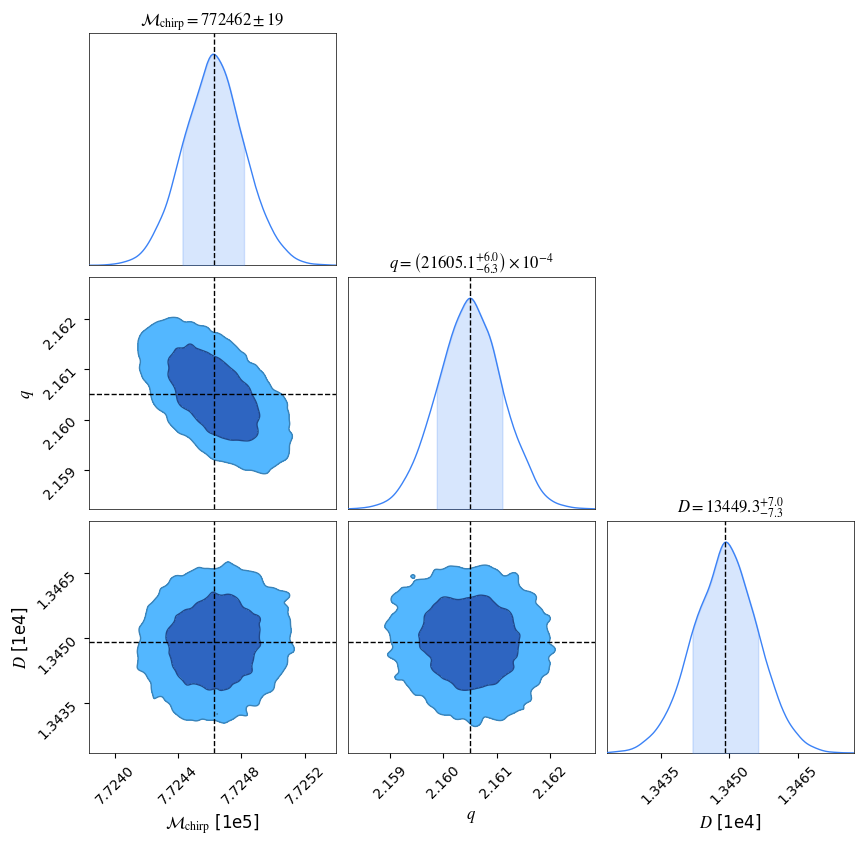

In [ ]:
burn = 100

samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 3)

dfs = pd.DataFrame(samples[burn:, :], columns=pnames)

c = ChainConsumer()
c.add_chain(Chain(samples=dfs, name="A first PE example"))
c.add_truth(Truth(location={pnames[0]: injection_params_sub[0],
                            pnames[1]: injection_params_sub[1],
                            pnames[2]: injection_params_sub[2]}))
fig = c.plotter.plot()

mpl.rcParams.update(rcparams)


We repeat the same for both channels:

In [ ]:
pMBHB_fit = copy.deepcopy(pMBHB)

# Remove those keys, otherwise the code will
# fit for m1 and m2 instead of Mchirp and q.
del pMBHB_fit["m1"]
del pMBHB_fit["m2"]

DA = Afull.copy()
DE = Efull.copy()

def likelihood_2chnls(pvector):

    Mc, q, dist = pvector[:]
    pMBHB_fit["Mchirp"] = Mc
    pMBHB_fit["q"] = q
    pMBHB_fit["dist"] = dist

    h_tdi = lisa.GenerateLISATDISignal_SMBH(pMBHB_fit, **waveform_params_smbh)['tdi'][(2,2)]

    # Phase
    splPh = spline(h_tdi['freq'], h_tdi['phase'])
    Ph = splPh(fvec)

    # A
    splAr = spline(h_tdi['freq'], h_tdi['amp_real_chan1'])
    splAi = spline(h_tdi['freq'], h_tdi['amp_imag_chan1'])
    hA = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*Ph))

    # E
    splEr = spline(h_tdi['freq'], h_tdi['amp_real_chan2'])
    splEi = spline(h_tdi['freq'], h_tdi['amp_imag_chan2'])
    hE = np.conjugate((splEr(fvec) + 1.j*splEi(fvec))*np.exp(1j*Ph))

    SN_m = 4.0 * df * np.sum( np.real(DA*np.conjugate(hA)) / Npsd ) \
          + 4.0 * df * np.sum( np.real(DE*np.conjugate(hE)) / Npsd )

    XX = 4.0 * df * np.sum( np.abs(hA)**2 / Npsd ) \
        + 4.0 * df * np.sum( np.abs(hE)**2 / Npsd )

    loglik = SN_m - 0.5*XX

    return loglik

In [ ]:
loglik =  likelihood_2chnls([pMBHB["Mchirp"], pMBHB["q"], pMBHB["dist"]])
print (f'for A-TDI likelihood is {loglik}')

for A-TDI likelihood is 3159338.5778931393


In [ ]:
sampler_2chnnls = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood_2chnls,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [ ]:
injection_params_sub = np.array([pMBHB_fit["Mchirp"], pMBHB_fit["q"], pMBHB_fit["dist"]])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

start_state = State({"mbh": start_params})

sampler_2chnnls.compute_log_prior(start_state.branches_coords);

In [ ]:
sampler_2chnnls.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 2000/2000 [23:17<00:00,  1.43it/s]


Text(0.5, 0, 'Samples')

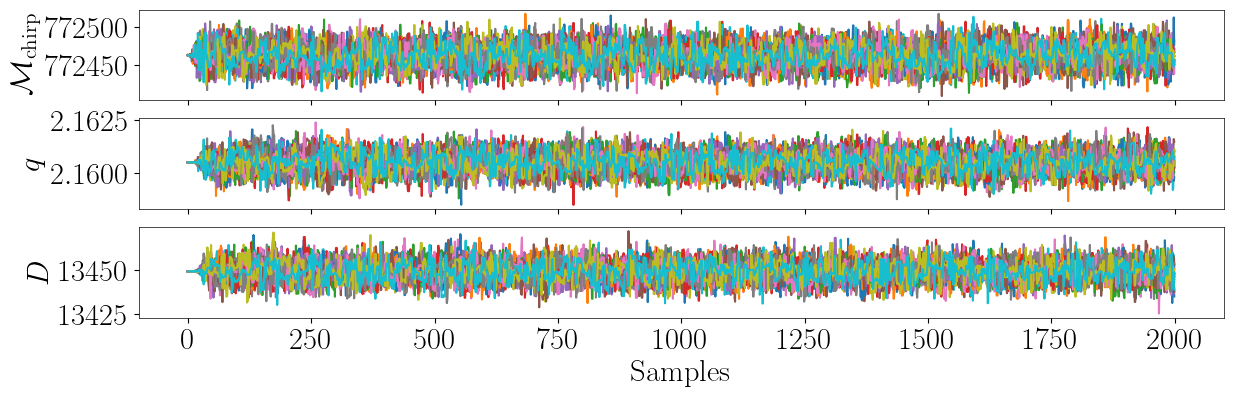

In [ ]:
samples_2ch = sampler_2chnnls.get_chain()["mbh"]

fig, axs = plt.subplots(nrows=len(pnames), ncols=1, figsize=(14,4), sharex=True)

for i in range(len(pnames)):
  for w in range(nwalkers):
      axs[i].plot(samples_2ch[:, 0, w, 0, i])
  axs[i].set_ylabel(pnames[i])

axs[-1].set_xlabel("Samples")

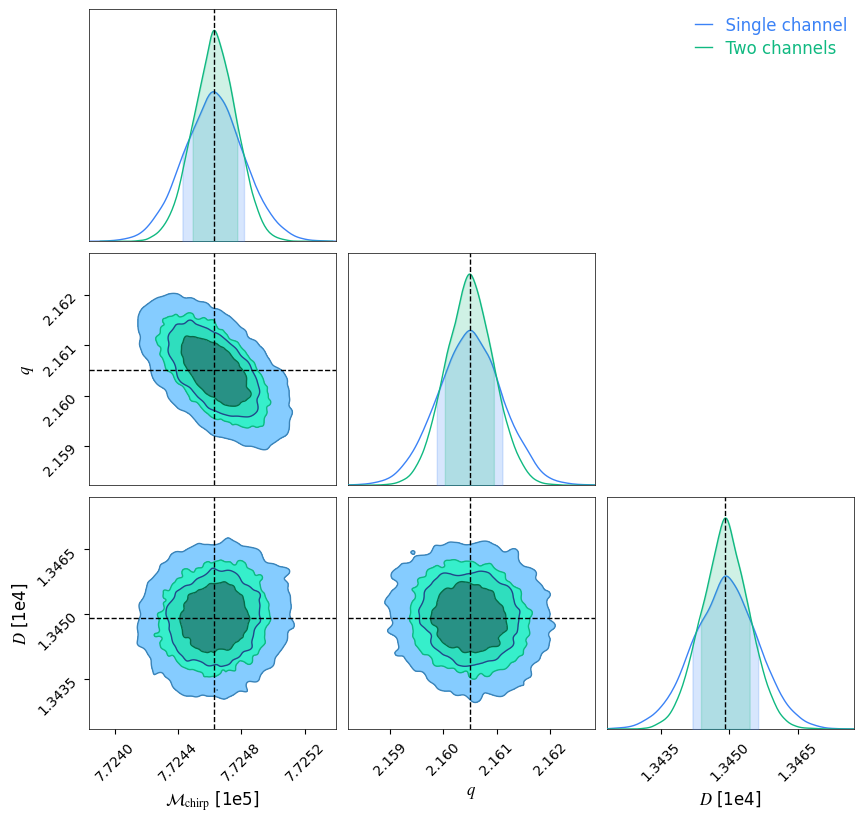

In [ ]:
burn = 100

samples_2ch = sampler_2chnnls.get_chain()["mbh"][:, 0].reshape(-1, 3)

dfs_2chnls = pd.DataFrame(samples_2ch[burn:, :], columns=pnames)

c = ChainConsumer()

c.add_chain(Chain(samples=dfs, name="Single channel"))
c.add_chain(Chain(samples=dfs_2chnls, name="Two channels"))

c.add_truth(Truth(location={pnames[0]: injection_params_sub[0],
                            pnames[1]: injection_params_sub[1],
                            pnames[2]: injection_params_sub[2]}))
fig = c.plotter.plot()

mpl.rcParams.update(rcparams)

## Example of a full result

Here is an example of a full PE. Posterior surfaces can be quite complex.

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=11aiF_awofaATk-YBdTSpIA9S_35wqxAs" -O chain_processed_pe_longsegment_ldc.npy
chain_processed_pe = np.load('chain_processed_pe_longsegment_ldc.npy')

--2024-10-06 17:03:01--  https://drive.google.com/uc?export=download&id=11aiF_awofaATk-YBdTSpIA9S_35wqxAs
Resolving drive.google.com (drive.google.com)... 74.125.139.139, 74.125.139.138, 74.125.139.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.139.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=11aiF_awofaATk-YBdTSpIA9S_35wqxAs&export=download [following]
--2024-10-06 17:03:01--  https://drive.usercontent.google.com/download?id=11aiF_awofaATk-YBdTSpIA9S_35wqxAs&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.216.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5632128 (5.4M) [application/octet-stream]
Saving to: ‘chain_processed_pe_longsegment_ldc.npy’

chain_processed_pe_ 100%[=============

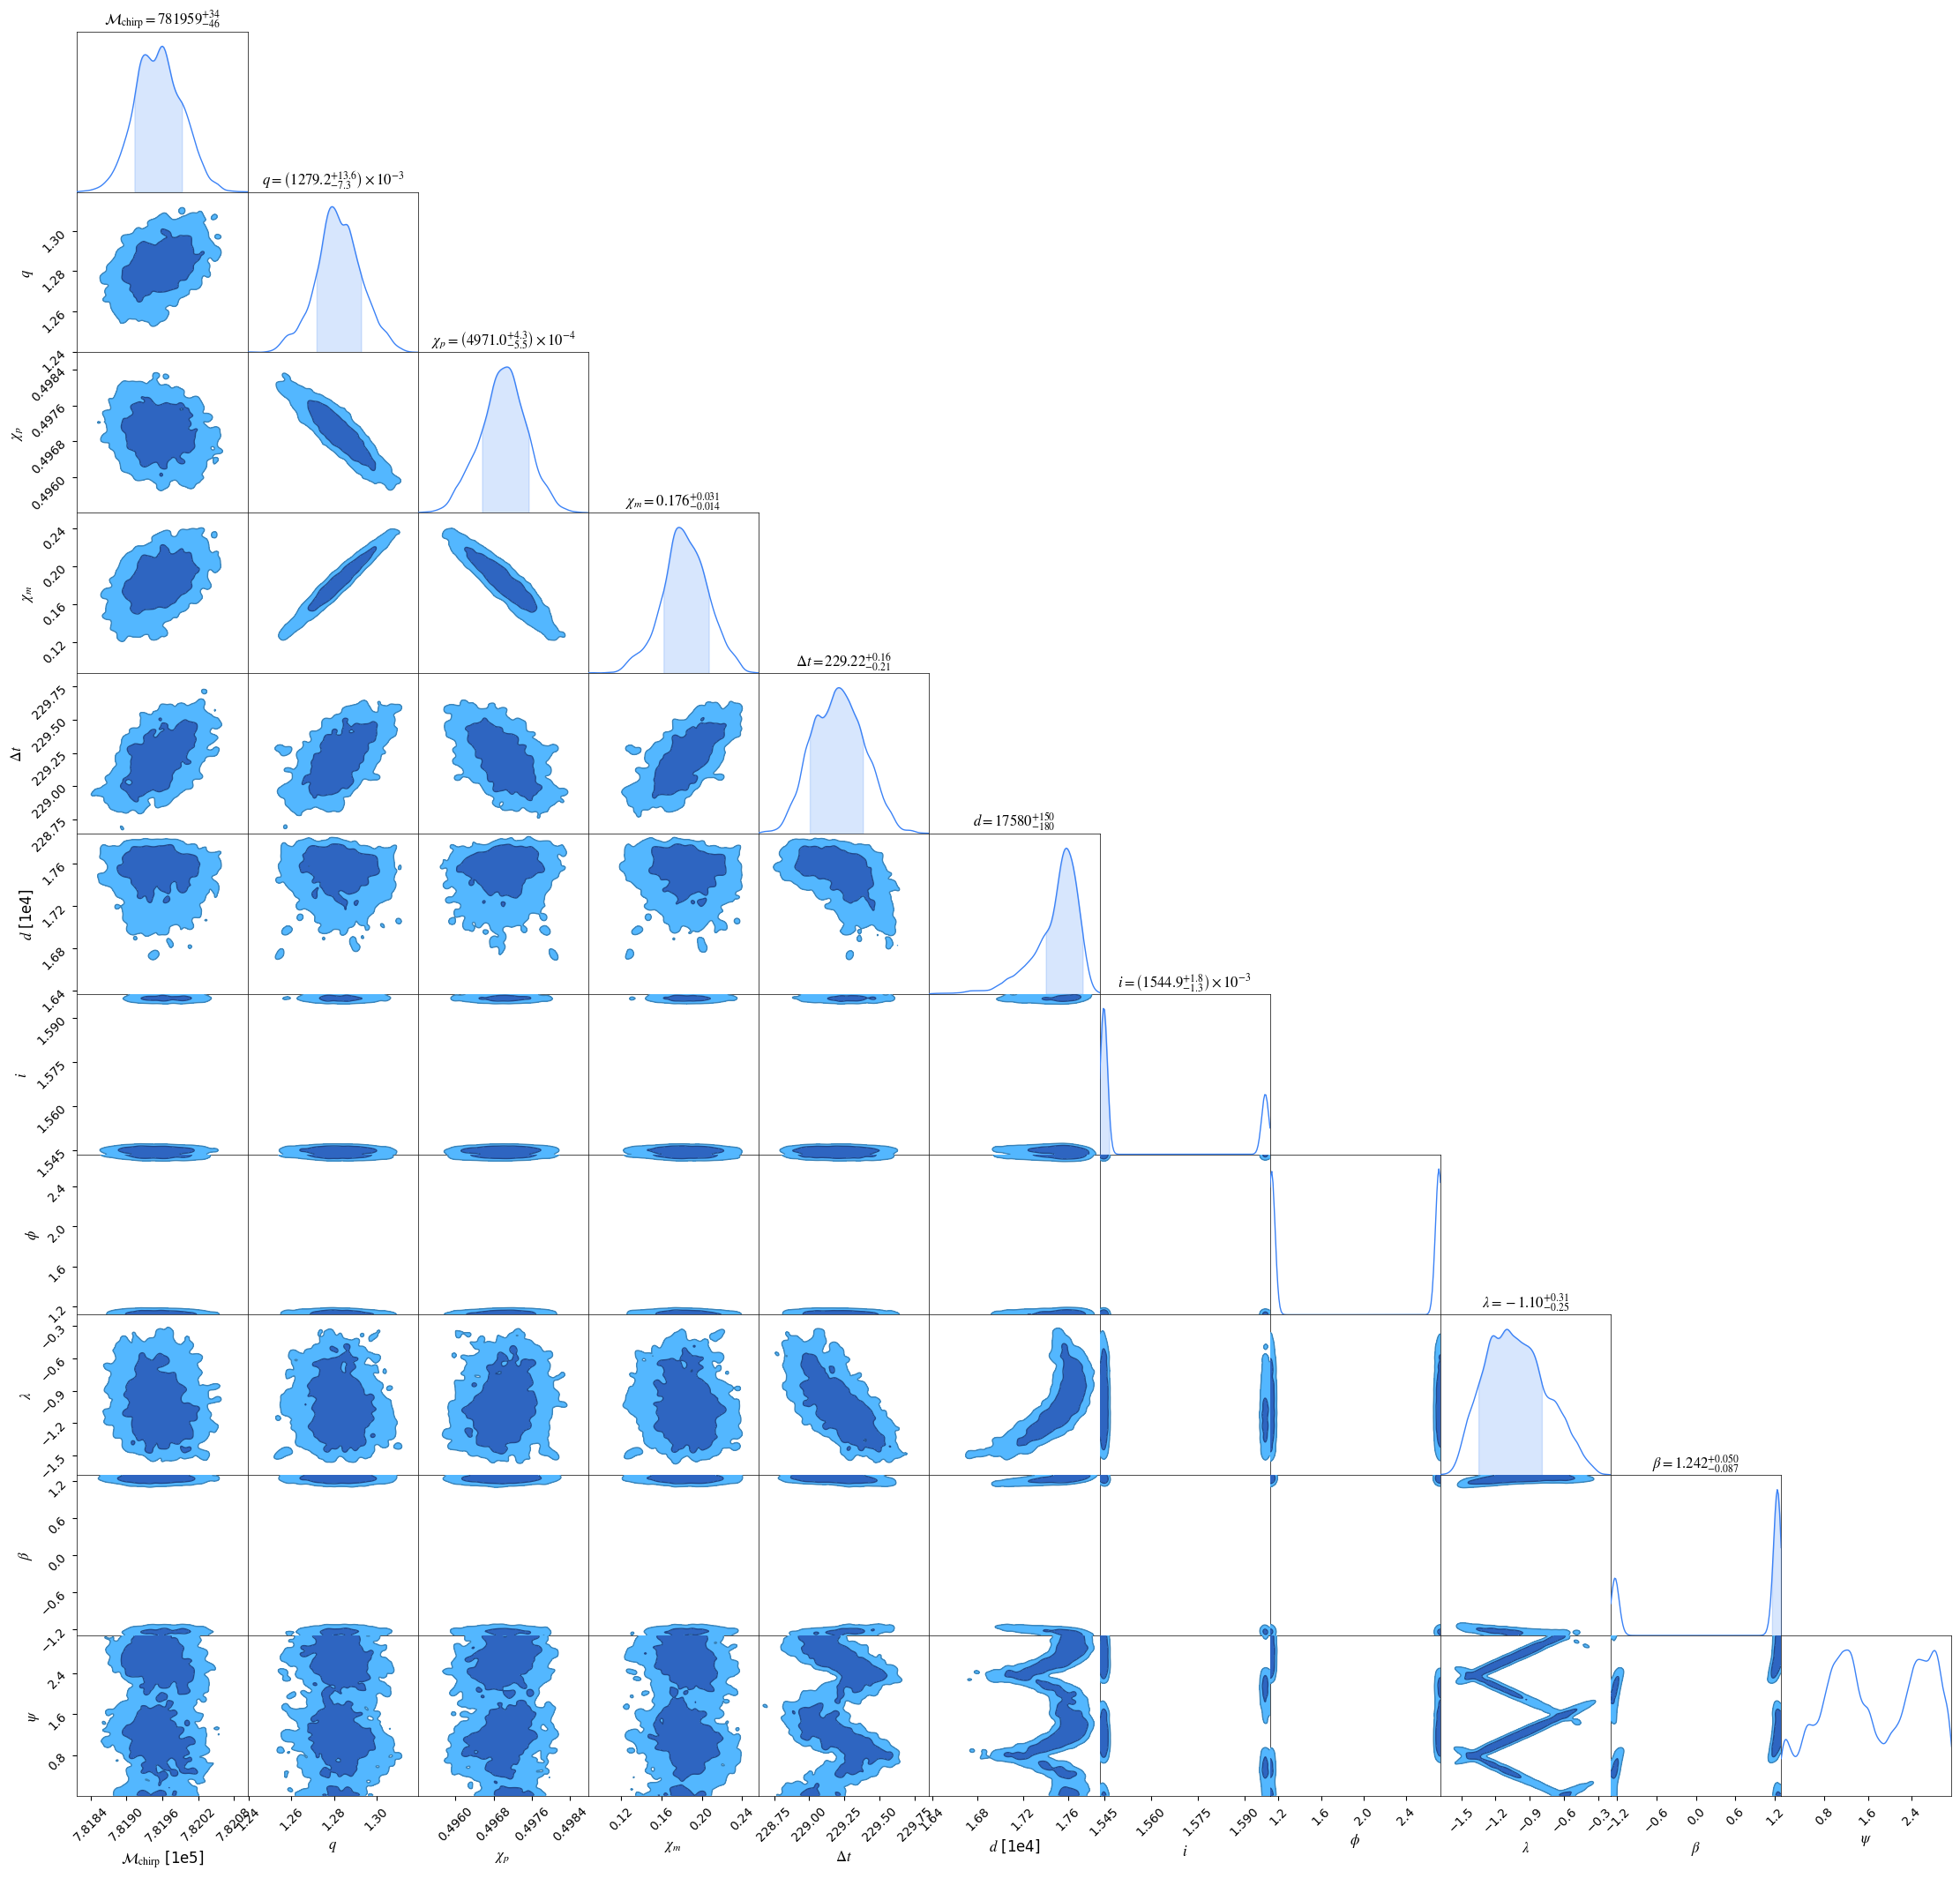

In [ ]:
c = ChainConsumer()

infer_params_full_pe = [
                   r"$\mathcal{M}_\mathrm{chirp}$",  "$q$",
                   r"$\chi_p$", r"$\chi_m$", r"$\Delta t$", "$d$",
                   "$i$", r"$\phi$", r"$\lambda$", r"$\beta$", r"$\psi$"]

chain_processed_pe_df = pd.DataFrame(chain_processed_pe, columns=infer_params_full_pe)

c.add_chain(Chain(samples=chain_processed_pe_df, name="A full PE example"))

fig = c.plotter.plot()

mpl.rcParams.update(rcparams)

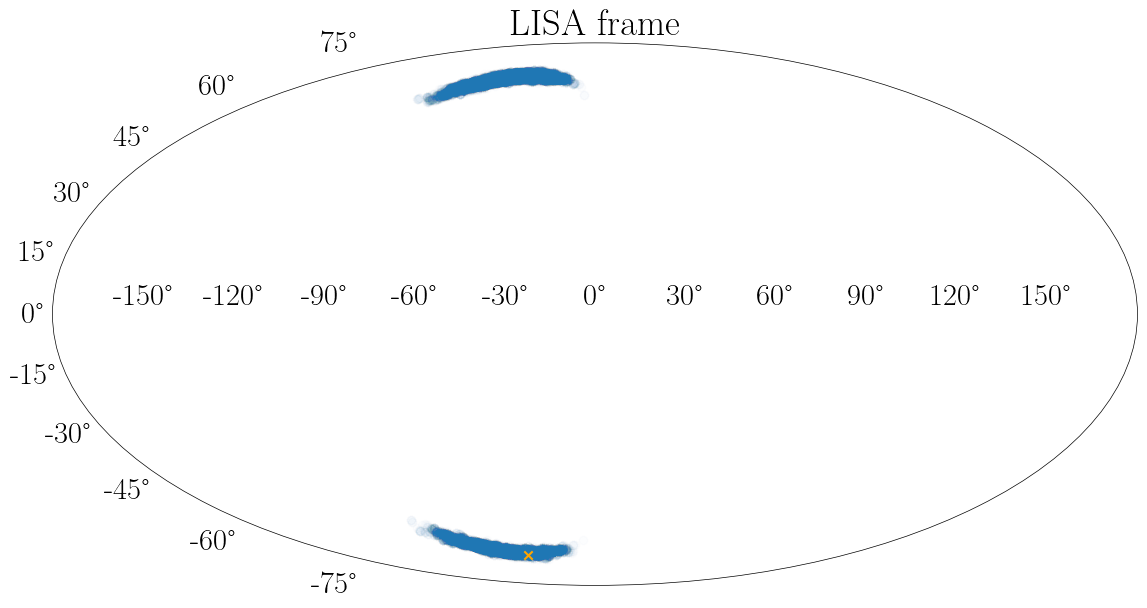

In [ ]:
lambd = chain_processed_pe[:,8]  ### longitude in the LISA-frame
beta = chain_processed_pe[:,9]  ### latitude in the LISA-frame

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='mollweide')
ax.set_title('LISA frame')
ax.scatter(lambd, beta, alpha=0.01)

params_ldc = {'Cadence': 3.0,
              'CoalescenceTime': 4800021.15572853,
              'Distance': 17758.367941273442,
              'EclipticLatitude': -0.5641023936335077,
              'EclipticLongitude': 0.6109268516130327,
              'InitialAzimuthalAngleL': 4.094550225563854,
              'InitialPolarAngleL': 2.5775388853549464,
              'Mass1': 1015522.4376,
              'Mass2': 796849.1091,
              'ObservationDuration': 31558149.763545603,
              'PhaseAtCoalescence': 4.275929308696054,
              'PolarAngleOfSpin1': 0.9089723456902256,
              'PolarAngleOfSpin2': 1.1816994499122777,
              'Redshift': 2.18186,
              'Spin1': 0.972661,
              'Spin2': 0.972862}

params_mbhb0 = FBH.rename_as_lisabeta(params_ldc)
tc_guess = 4799395.0
params_mbhb0['Deltat'] -= tc_guess
# Conventions for the angles (not really required)
params_mbhb0['phi'] = pytools.mod2pi(params_mbhb0['phi'])
params_mbhb0['psi'] = pytools.modpi(params_mbhb0['psi'])

params_mbhb0_Lframe = lisatools.convert_SSBframe_to_Lframe(params_mbhb0, t0=tc_guess/lisaconstants.ASTRONOMICAL_YEAR)

ax.scatter(params_mbhb0_Lframe['lambda'], params_mbhb0_Lframe['beta'], c='orange', marker='x')

## Acceleration!



*   Use vectorized code when possible: For example, many samplers support vectorized likelihood functions. This means that we can develope a setup, where the input is a 2d array of parameter values, and compute the (also vectorized) model for this array of parameter values. This allows us to compute the likelihood for each walker avoiding MCMC loops.
*   Use Parallelization where possible (e.g. parallelize each walker).
*   Use of GPUs! Configurations such as the above vectorized likelihoods are ideal for GPU hardware.
* Heterodyne Likelihoods (Natalias' presentation, or see [2109.02728](https://arxiv.org/abs/2109.02728))
* Proposals!



## D. Using synthetic data from the available simulators

This section attempts to load the data from session and directly fit the signal that was generated. Probably there is no time to go through this, but it's the next natural step.

In [ ]:
!gdown 1qur7TpSbZBAqB9pWkAXUwrxFY6Y7rn0T
!gdown 1NX6ypNpNR4c0CbUo0DDt9pV_Knrczjev

Downloading...
From: https://drive.google.com/uc?id=1qur7TpSbZBAqB9pWkAXUwrxFY6Y7rn0T
To: /content/simulation-gws-tdi2.h5
100% 2.40M/2.40M [00:00<00:00, 79.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NX6ypNpNR4c0CbUo0DDt9pV_Knrczjev
To: /content/simulation-noise-gws-tdi2.h5
100% 2.40M/2.40M [00:00<00:00, 35.6MB/s]


In [ ]:
fname = 'simulation-noise-gws-tdi2.h5'

hdf5 = h5py.File(fname, 'r')

In [ ]:
X = hdf5["X"]
Y = hdf5["Y"]
Z = hdf5["Z"]

In [ ]:
fname = 'simulation-gws-tdi2.h5'

hdf5 = h5py.File(fname, 'r')

Xgw = hdf5["X"]
Ygw = hdf5["Y"]
Zgw = hdf5["Z"]

In [ ]:
t_start = 11502945.0
dt = .25
fs = 1/dt
tvec = t_start + np.arange(0, len(X)) * dt

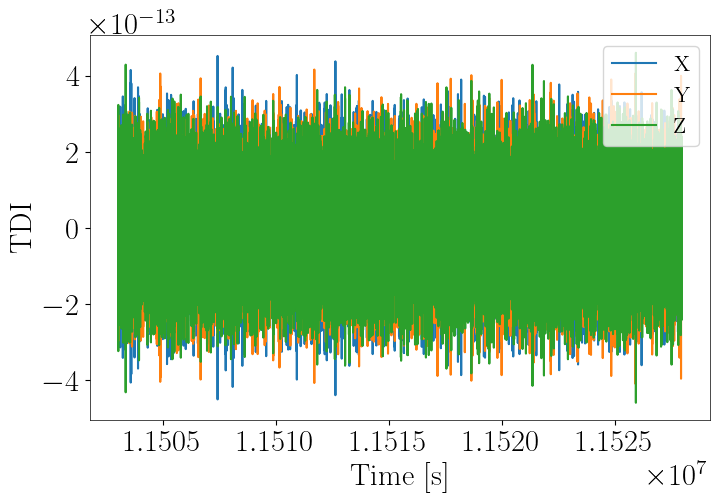

In [ ]:
skip = 300

plt.figure(figsize=(8,5))
plt.plot(tvec[skip:], X[skip:], label="X")
plt.plot(tvec[skip:], Y[skip:], label="Y")
plt.plot(tvec[skip:], Z[skip:], label="Z")
plt.xlabel("Time [s]")
plt.ylabel("TDI")
plt.legend()

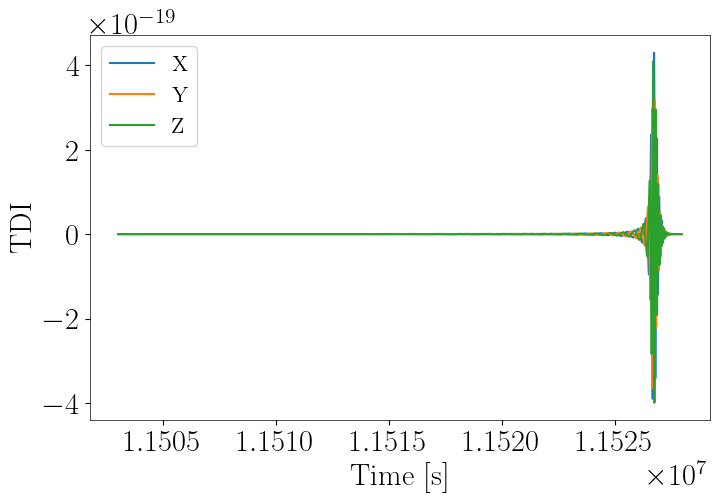

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(tvec[skip:], Xgw[skip:], label="X")
plt.plot(tvec[skip:], Ygw[skip:], label="Y")
plt.plot(tvec[skip:], Zgw[skip:], label="Z")
plt.xlabel("Time [s]")
plt.ylabel("TDI")
plt.legend()

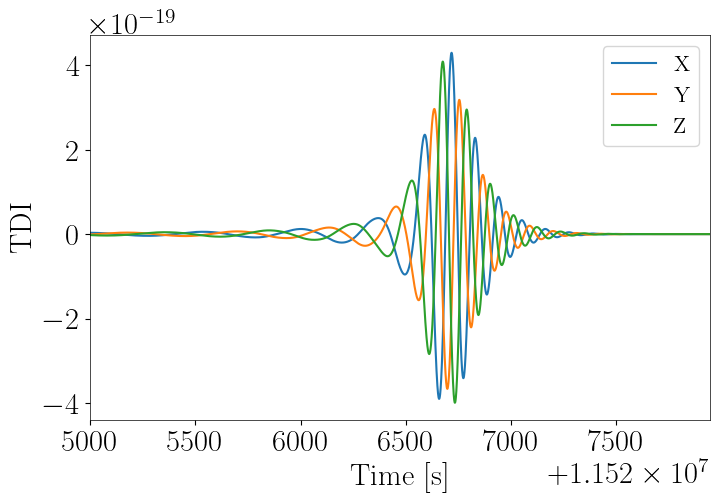

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(tvec[skip:], Xgw[skip:], label="X")
plt.plot(tvec[skip:], Ygw[skip:], label="Y")
plt.plot(tvec[skip:], Zgw[skip:], label="Z")
plt.xlabel("Time [s]")
plt.ylabel("TDI")
plt.xlim(1.1525e7,tvec[-1])
plt.legend()

Use the `lisabeta` tools to compute the FFT. Perform some initial tests.

In [ ]:
w = pytools.window_planck_vec(tvec[skip:], tvec[skip], tvec[-1], 3600., 1000.)

test_fs = pytools.fft_positivef(np.array([tvec[skip:], w * Xgw[skip:]]).T)

Text(0.5, 0, 'Frequency [Hz]')

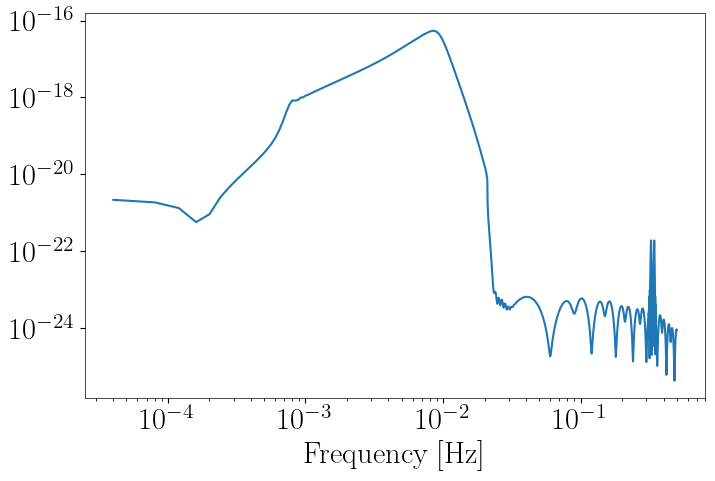

In [ ]:
freq = test_fs[:,0]
mask = (1e-5 <= freq) & (freq <= 0.5)
plt.figure(figsize=(8,5))
plt.loglog(freq[mask], np.abs(test_fs[mask,1] + 1j*test_fs[mask,2]))
plt.xlabel('Frequency [Hz]')

Let us now take a look at the data. Compute the PSD for each channel:

In [ ]:
f, psd_X2 = scipy.signal.welch(X[skip:],
                               fs=fs,
                               nperseg=len(X[skip:]))
f, psd_Y2 = scipy.signal.welch(Y[skip:],
                               fs=fs,
                               nperseg=len(Y[skip:]))
f, psd_Z2 = scipy.signal.welch(Z[skip:],
                               fs=fs,
                               nperseg=len(Z[skip:]))


In [ ]:
f, psd_X2gw = scipy.signal.welch(Xgw[skip:],
                               fs=fs,
                               nperseg=len(Xgw[skip:]))
f, psd_Y2gw = scipy.signal.welch(Ygw[skip:],
                               fs=fs,
                               nperseg=len(Ygw[skip:]))
f, psd_Z2gw = scipy.signal.welch(Zgw[skip:],
                               fs=fs,
                               nperseg=len(Zgw[skip:]))

In [ ]:
LISAnoisemodel = get_noise_model('sangria', f)

LISAnoisepsd = LISAnoisemodel.psd(f,
                                  option="X",
                                  tdi2=True,
                                  equal_arms=True)

/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:302: RuntimeWarning: divide by zero encountered in divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:304: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:305: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:309: RuntimeWarning: divide by zero encountered in divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:311: RuntimeWarning: invalid value encountered in multiply
  s_oms_nu = self.psd_oms_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/no

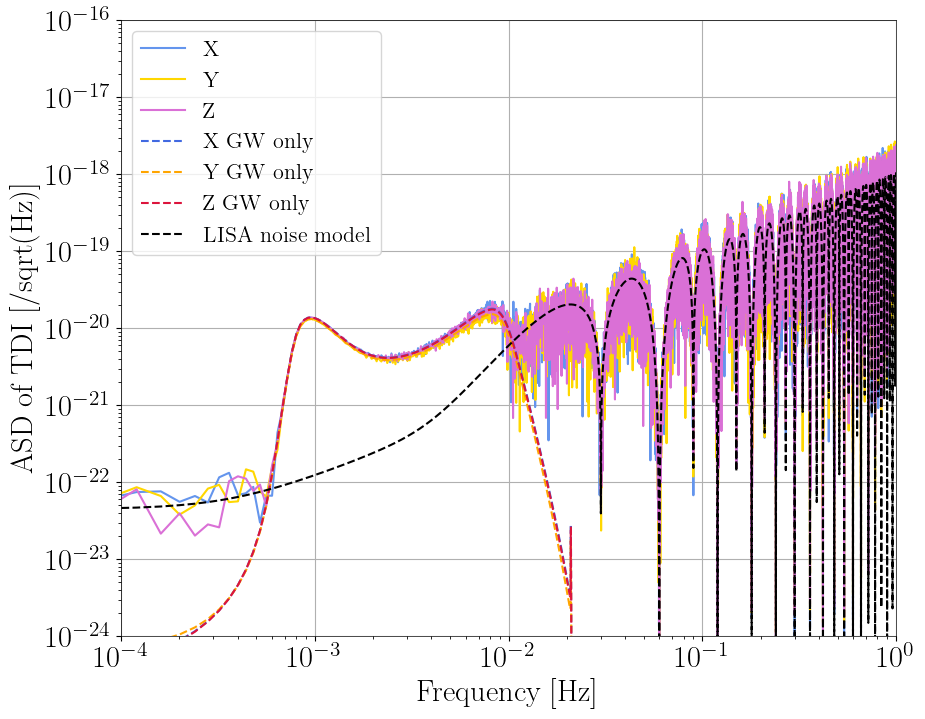

In [ ]:
plt.figure(figsize=(10,8))

plt.loglog(f, np.sqrt(psd_X2), color='cornflowerblue', label = 'X')
plt.loglog(f, np.sqrt(psd_Y2), color='gold', label = 'Y')
plt.loglog(f, np.sqrt(psd_Z2), color='orchid', label = 'Z')

plt.loglog(f, np.sqrt(psd_X2gw), color='royalblue', linestyle='--', label = 'X GW only')
plt.loglog(f, np.sqrt(psd_Y2gw), color='orange', linestyle='--', label = 'Y GW only')
plt.loglog(f, np.sqrt(psd_Z2gw), color='crimson', linestyle='--', label = 'Z GW only')

plt.loglog(f, np.sqrt(LISAnoisepsd), 'k--', label= 'LISA noise model')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r"ASD of TDI [/sqrt(Hz)]")
plt.xlim([1e-4, 1]) # restrict frequency band
plt.ylim([1e-24, 1e-16]) # restrict frequency band
plt.grid()
plt.legend(loc="upper left")

This signal looks a bit strange at lower frequencies. This seems to be a problem that could be improved with windowing.

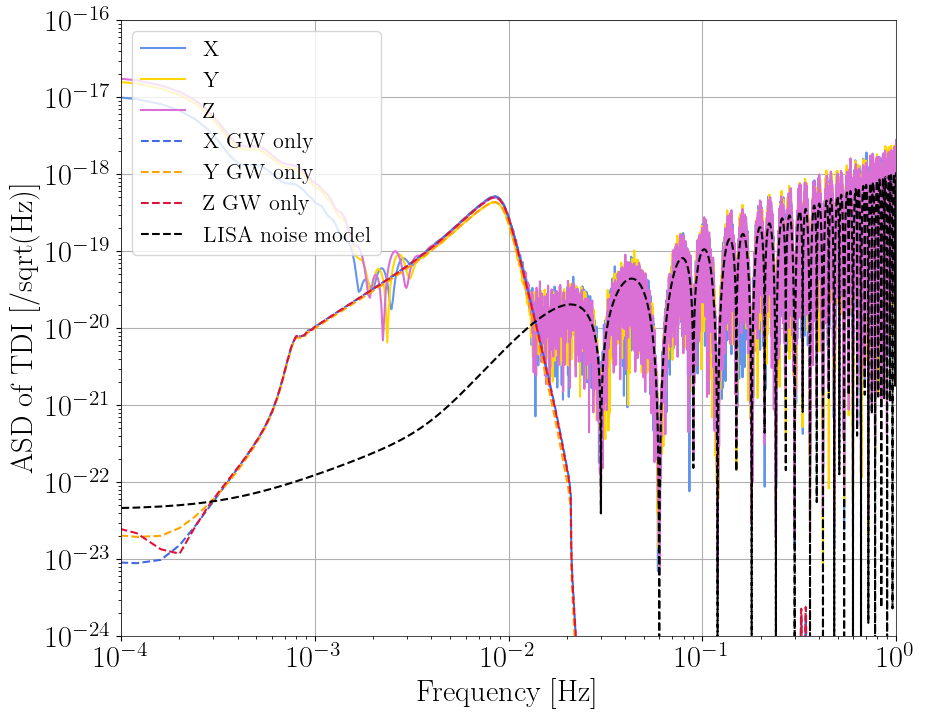

In [ ]:
win = pytools.window_planck_vec(tvec[skip:], tvec[skip], tvec[-1], 3600., 1000.)

f, psd_X2 = scipy.signal.welch(X[skip:],
                               fs=fs, window=win,
                               nperseg=len(X[skip:]))
f, psd_Y2 = scipy.signal.welch(Y[skip:],
                               fs=fs,window=win,
                               nperseg=len(Y[skip:]))
f, psd_Z2 = scipy.signal.welch(Z[skip:],
                               fs=fs,window=win,
                               nperseg=len(Z[skip:]))


f, psd_X2gw = scipy.signal.welch(Xgw[skip:],
                               fs=fs,window=win,
                               nperseg=len(Xgw[skip:]))
f, psd_Y2gw = scipy.signal.welch(Ygw[skip:],
                               fs=fs,window=win,
                               nperseg=len(Ygw[skip:]))
f, psd_Z2gw = scipy.signal.welch(Zgw[skip:],
                               fs=fs,window=win,
                               nperseg=len(Zgw[skip:]))


plt.figure(figsize=(10,8))

plt.loglog(f, np.sqrt(psd_X2), color='cornflowerblue', label = 'X')
plt.loglog(f, np.sqrt(psd_Y2), color='gold', label = 'Y')
plt.loglog(f, np.sqrt(psd_Z2), color='orchid', label = 'Z')

plt.loglog(f, np.sqrt(psd_X2gw), color='royalblue', linestyle='--', label = 'X GW only')
plt.loglog(f, np.sqrt(psd_Y2gw), color='orange', linestyle='--', label = 'Y GW only')
plt.loglog(f, np.sqrt(psd_Z2gw), color='crimson', linestyle='--', label = 'Z GW only')

plt.loglog(f, np.sqrt(LISAnoisepsd), 'k--', label= 'LISA noise model')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r"ASD of TDI [/sqrt(Hz)]")
plt.xlim([1e-4, 1]) # restrict frequency band
plt.ylim([1e-24, 1e-16]) # restrict frequency band
plt.grid()
plt.legend(loc="upper left")

Transform to the noise orthogonal TDI variables

In [ ]:
def toAET(X,Y,Z):
    A = (Z - X)/np.sqrt(2.0)
    E = (X - 2.0*Y + Z)/np.sqrt(6.0)
    T = (X + Y + Z)/np.sqrt(3.0)
    return A, E, T

In [ ]:
A, E, T = toAET(np.array(X), np.array(Y), np.array(Z))
Agw, Egw, Tgw = toAET(np.array(Xgw), np.array(Ygw), np.array(Zgw))

In [ ]:
# win = scipy.signal.windows.get_window('tukey', len(A)-skip)
win = pytools.window_planck_vec(tvec[skip:], tvec[skip], tvec[-1], 3600., 1000.)

f, psd_A2 = scipy.signal.welch(A[skip:],
                               fs=fs, window=win,
                               nperseg=len(A[skip:]))
f, psd_E2 = scipy.signal.welch(E[skip:],
                               fs=fs, window=win,
                               nperseg=len(E[skip:]))
f, psd_T2 = scipy.signal.welch(T[skip:],
                               fs=fs, window=win,
                               nperseg=len(T[skip:]))

f, psd_A2gw = scipy.signal.welch(Agw[skip:],
                               fs=fs, window=win,
                               nperseg=len(Agw[skip:]))
f, psd_E2gw = scipy.signal.welch(Egw[skip:],
                               fs=fs, window=win,
                               nperseg=len(Egw[skip:]))
f, psd_T2gw = scipy.signal.welch(Tgw[skip:],
                               fs=fs, window=win,
                               nperseg=len(Tgw[skip:]))

LISAnoisepsdAE = LISAnoisemodel.psd(f[1:],
                                  option="A",
                                  tdi2=True,
                                  equal_arms=True)

LISAnoisepsdT = LISAnoisemodel.psd(f[1:],
                                  option="T",
                                  tdi2=True,
                                  equal_arms=True)

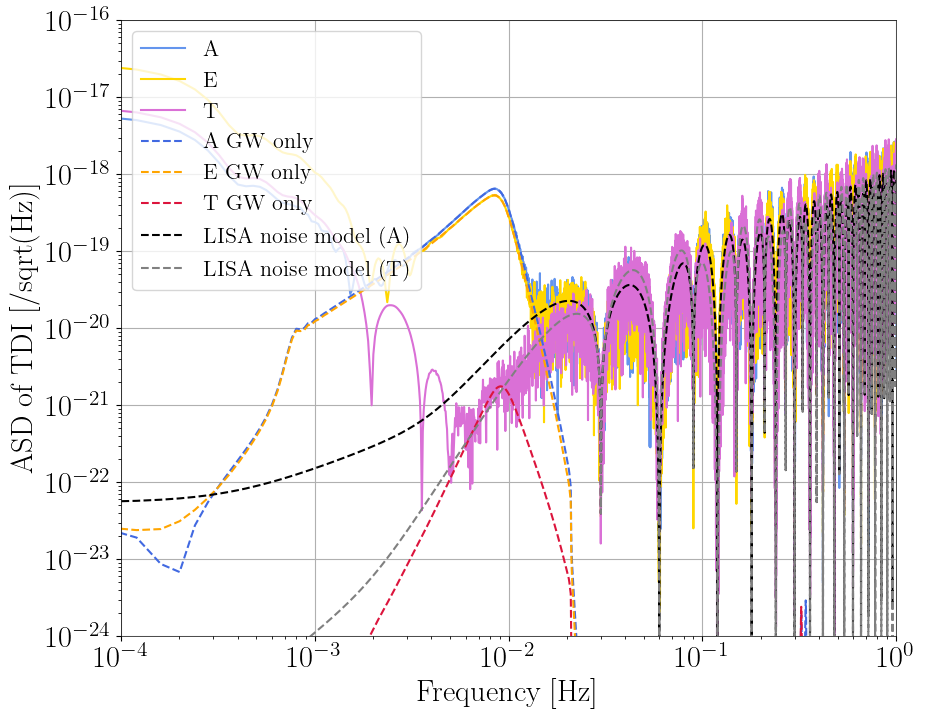

In [ ]:
plt.figure(figsize=(10,8))

plt.loglog(f, np.sqrt(psd_A2), color='cornflowerblue', label = 'A')
plt.loglog(f, np.sqrt(psd_E2), color='gold', label = 'E')
plt.loglog(f, np.sqrt(psd_T2), color='orchid', label = 'T')

plt.loglog(f, np.sqrt(psd_A2gw), color='royalblue', linestyle='--', label = 'A GW only')
plt.loglog(f, np.sqrt(psd_E2gw), color='orange', linestyle='--', label = 'E GW only')
plt.loglog(f, np.sqrt(psd_T2gw), color='crimson', linestyle='--', label = 'T GW only')

plt.loglog(f[1:], np.sqrt(LISAnoisepsdAE), 'k--', label= 'LISA noise model (A)')
plt.loglog(f[1:], np.sqrt(LISAnoisepsdT), color='gray', linestyle='--', label= 'LISA noise model (T)')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r"ASD of TDI [/sqrt(Hz)]")
plt.xlim([1e-4, 1]) # restrict frequency band
plt.ylim([1e-24, 1e-16]) # restrict frequency band
plt.grid()
plt.legend(loc="upper left")

Define the MBH model again, to fit the data

In [ ]:
tmax = pMBHB_ldc["CoalescenceTime"]+5000
FBH = FastBHB("MBHB", T=tmax, delta_t=dt, approx="IMRPhenomD")

In [ ]:
from ldc.common.constants import ASTRONOMICAL_YEAR

# auxiliary parameters
waveform_params_smbh = {
    "minf": 1e-5,
    "maxf": 0.1,
    "t0": pMBHB_ldc["CoalescenceTime"]/ASTRONOMICAL_YEAR, # 0.0,
    "toffset": pMBHB_ldc["CoalescenceTime"]/ASTRONOMICAL_YEAR, # 0.0,
    "timetomerger_max": None,
    "fend": None,
    "tmin": tvec[0]/ASTRONOMICAL_YEAR,
    "tmax": 1.0,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": True,
    "modes": None,
    "TDI": "TDI2AET",
    "acc": 1e-4,
    "order_fresnel_stencil": 0,
    "approximant": "IMRPhenomD",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": False,
}

In [ ]:
pMBHB = FBH.rename_as_lisabeta(pMBHB_ldc)

tdisignal = lisa.GenerateLISATDISignal_SMBH(pMBHB, **waveform_params_smbh)
tdi = tdisignal['tdi']
mbh_lb = tdi[(2,2)]

In [ ]:
 # frequency band of the signal
fmin = mbh_lb['freq'][0]
fmax = mbh_lb['freq'][-1]
tobs = tvec[-1] - tvec[0]
ndata = int(tobs/dt)
df = 1/tobs

# Get the full frequencies
if (ndata % 2)==0:              # Get the number of requencies
    nfft = int((ndata/2)+1)
else:
    nfft = int((ndata+1)/2)

F = df*nfft                 # make the positive frequency vector
fvec = np.arange(0, F, df)

# Get the frequencies of interest
f_inds = np.where(np.logical_and(fvec >= fmin, fvec < fmax))
fvec = fvec[f_inds]

# constructing spline
splPh = spline(mbh_lb['freq'], mbh_lb['phase'])
splAr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan1'])
splAi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan1'])

# constructing signal at each Fouriner freq.
Afull = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*splPh(fvec)))

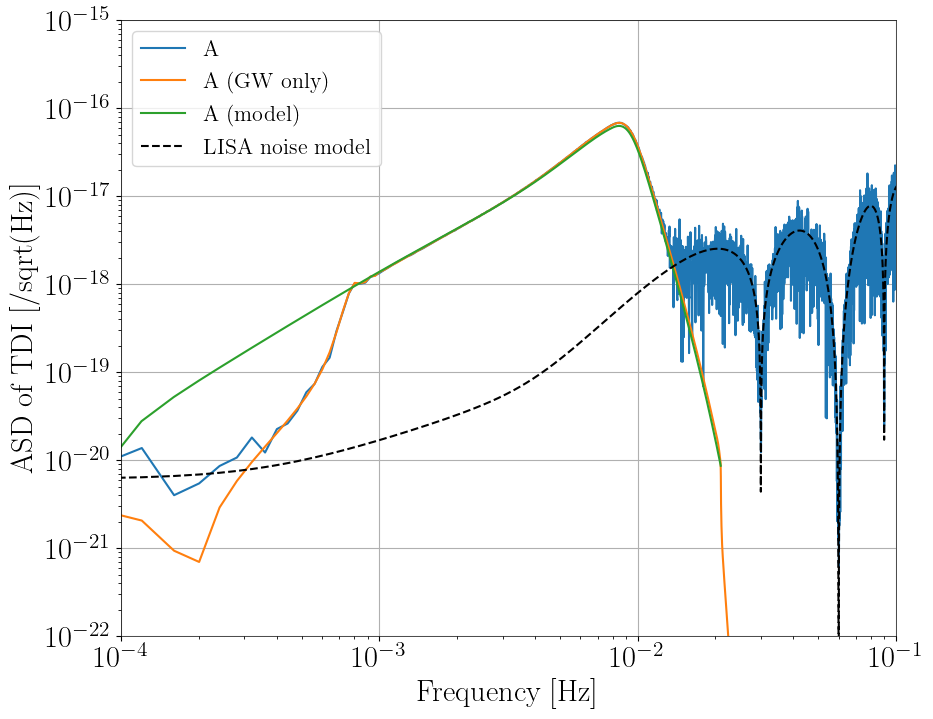

In [ ]:
w = pytools.window_planck_vec(tvec[skip:], tvec[skip], tvec[-1], 3600., 1000.)

plt.figure(figsize=(10,8))

A_fs = pytools.fft_positivef(np.array([tvec[skip:], w * A[skip:]]).T)

freqvec = A_fs[:,0]
mask = (1e-5 <= freqvec) & (freqvec <= 0.5)

plt.loglog(freqvec[mask], np.abs((A_fs[mask,1] + 1j*A_fs[mask,2])), label = 'A')

A_fs_gw = pytools.fft_positivef(np.array([tvec[skip:], w * Agw[skip:]]).T)

plt.loglog(freqvec[mask], np.abs((A_fs_gw[mask,1] + 1j*A_fs_gw[mask,2])), linestyle='-', label = 'A (GW only)')

plt.loglog(fvec, np.abs(Afull), linestyle='-', label = 'A (model)')

# Compute df
deltaf = np.abs(freqvec[1]-freqvec[0])

plt.loglog(f[1:], np.sqrt(0.5*LISAnoisepsdAE/deltaf), 'k--', label= 'LISA noise model')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r"ASD of TDI [/sqrt(Hz)]")
plt.xlim([1e-4, 1e-1]) # restrict frequency band
plt.ylim([1e-22, 1e-15]) # restrict frequency band
plt.grid()
plt.legend(loc="upper left")

In [ ]:
print(fvec.shape, freqvec[mask].shape, freqvec.shape, f.shape, fvec[0], fvec[-1], f[-1])

(523,) (12462,) (49850,) (49851,) 8.000080000800008e-05 0.02096020960209602 2.0


Proceed with defining the likelihood function. We can keep only the frequencies of interest for this particular example.

In [ ]:
new_mask = (1e-3 <= freqvec) & (freqvec <= 2e-2)
DA = (A_fs[new_mask,1] + 1j*A_fs[new_mask,2])

In [ ]:
m1 = pMBHB['m1']
m2 = pMBHB['m2']

q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

pMBHB["Mchirp"] = Mc
pMBHB["q"] = q

pMBHB_fit = copy.deepcopy(pMBHB)

# Remove those keys, otherwise the code will
# fit for m1 and m2 instead of Mchirp and q.
del pMBHB_fit["m1"]
del pMBHB_fit["m2"]

In [ ]:
fvec_to_use = freqvec[new_mask]

In [ ]:
Nmodel = AnalyticNoise(fvec_to_use, model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

In [ ]:


def likelihood_d(pvector):

    Mc, q, dist = pvector[:]
    pMBHB_fit["Mchirp"] = Mc
    pMBHB_fit["q"] = q
    pMBHB_fit["dist"] = dist

    h_tdi = lisa.GenerateLISATDISignal_SMBH(pMBHB_fit, **waveform_params_smbh)['tdi'][(2,2)]

    splPh = spline(h_tdi['freq'], h_tdi['phase'])
    splAr = spline(h_tdi['freq'], h_tdi['amp_real_chan1'])
    splAi = spline(h_tdi['freq'], h_tdi['amp_imag_chan1'])

    h = np.conjugate((splAr(fvec_to_use) + 1.j*splAi(fvec_to_use))*np.exp(1j*splPh(fvec_to_use)))

    SN_m = 4.0*df* np.sum( np.real(DA*np.conjugate(h))/Npsd )
    XX = 4.0*df* np.sum( np.abs(h)**2/Npsd )
    loglik = SN_m - 0.5*XX

    return loglik

In [ ]:
loglik =  likelihood_d([pMBHB["Mchirp"], pMBHB["q"], pMBHB["dist"]])
print (f'for A-TDI likelihood is {loglik}')

for A-TDI likelihood is -1640686.5785002755


In [ ]:
ntemps = 5
nwalkers = 20
nsamples = 2000
ndims = {"mbh": 3}

In [ ]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 1e7),
    1: uniform_dist(1, 10),
    2: uniform_dist(500.0, 1000000.0),
})}

In [ ]:
sampler_d = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood_d,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [ ]:
injection_params_sub = np.array([pMBHB_fit["Mchirp"], pMBHB_fit["q"], pMBHB_fit["dist"]])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

start_state = State({"mbh": start_params})

sampler_d.compute_log_prior(start_state.branches_coords);

In [ ]:
sampler_d.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 2000/2000 [05:19<00:00,  6.26it/s]


Text(0.5, 0, 'Samples')

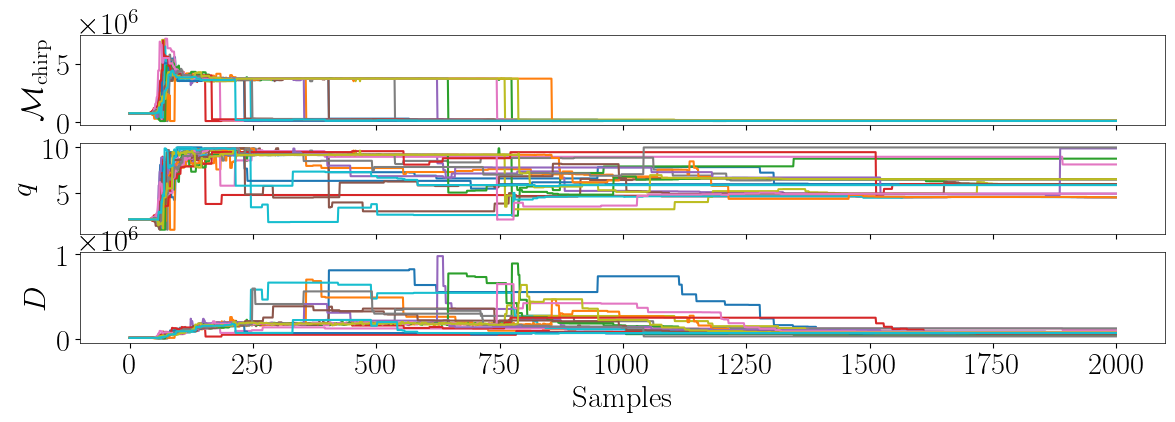

In [ ]:
samples_d = sampler_d.get_chain()["mbh"]

pnames = [r"$\mathcal{M}_\mathrm{chirp}$", "$q$", "$D$"]

fig, axs = plt.subplots(nrows=len(pnames), ncols=1, figsize=(14,4), sharex=True)

for i in range(len(pnames)):
  for w in range(nwalkers):
      axs[i].plot(samples_d[:, 0, w, 0, i])
  axs[i].set_ylabel(pnames[i])

axs[-1].set_xlabel("Samples")

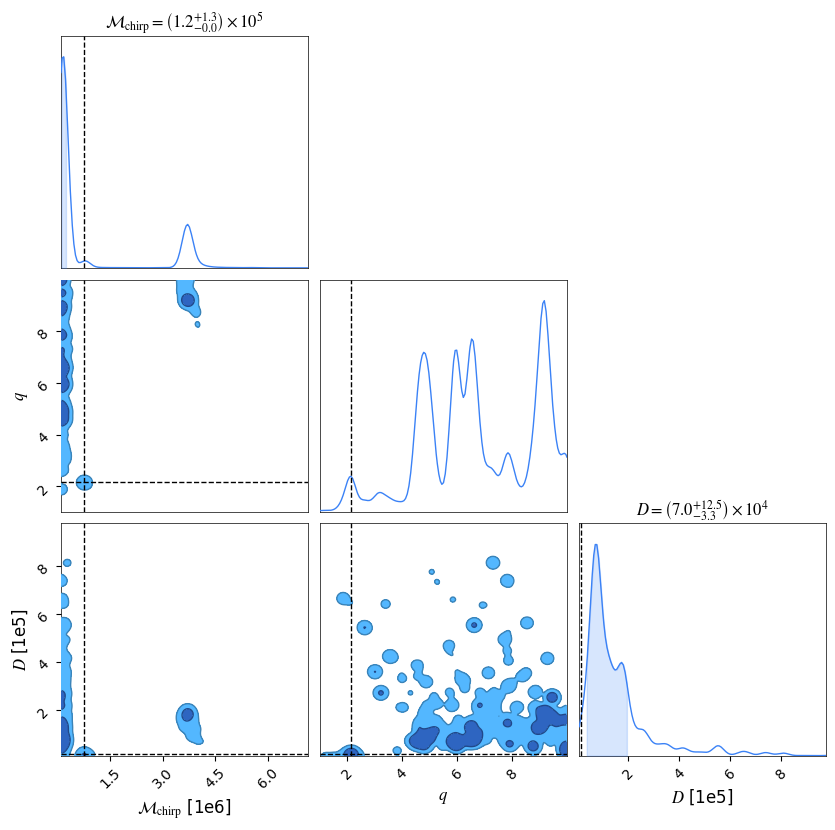

In [ ]:
burn = 100

samples_d = sampler_d.get_chain()["mbh"][:, 0].reshape(-1, 3)

dfs_d = pd.DataFrame(samples_d[burn:, :], columns=pnames)

c = ChainConsumer()

c.add_chain(Chain(samples=dfs_d, name="Using data"))

c.add_truth(Truth(location={pnames[0]: injection_params_sub[0],
                            pnames[1]: injection_params_sub[1],
                            pnames[2]: injection_params_sub[2]}))
fig = c.plotter.plot()

mpl.rcParams.update(rcparams)

# $fin$